# Noise Analysis
In thi notebook we test the effect of noisy inputs to the model.

In [74]:
%reload_ext autoreload
%autoreload 2

# from common.metrics.gradient import Gradient
import torch
from torch.utils.data import DataLoader
import torchinfo
import numpy as np
import pandas as pd
import pytorch_lightning as pl 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from pylab import *
import ast
import os
import sys
from statistics import mean
import warnings


# import modules from JTAG model
module_path = os.path.abspath(os.path.join('../../workspace/models/jets/code/')) # or the path to your source code
sys.path.insert(0, module_path)
from model import JetTagger
from jet_datamodule import JetDataModule

# import modules from ECON model
module_path = os.path.abspath(os.path.join('../../workspace/models/econ/code/')) # or the path to your source code
sys.path.insert(0, module_path)
from q_autoencoder import AutoEncoder
from autoencoder_datamodule import AutoEncoderDataModule

# import modules from common metrics
module_path = os.path.abspath(os.path.join('../../workspace/common/metrics/')) # or the path to your source code
sys.path.insert(0, module_path)
from CKA import CKA
from neural_efficiency import NeuralEfficiency


# import modules from common benchmarks
module_path = os.path.abspath(os.path.join('../../workspace/common/benchmarks/')) # or the path to your source code
sys.path.insert(0, module_path)
from noisy_dataset import NoisyDataset



DATA_PATH = '/home/jovyan/checkpoint/'
DATASET_DIR = '../../data/ECON/Elegun'
DATASET_FILE = 'nELinks5.npy'

## Utility methods

In [75]:
def plot_2d_heatmap(values, 
                    title, 
                    min_max=(0, 1), 
                    x_label='Layers', 
                    y_label='Layers', 
                    scale_label='Value', 
                    cmap='Greens',
                    show_value=True):
    '''
    Method used to plot a 2D heatmap using Seaborn.
    '''
    # Set up the figure and axes
    plt.figure(figsize=(7, 6))

    # Create a heatmap using Seaborn
    sns.heatmap(values, 
                cmap=cmap, 
                annot=show_value, 
                fmt=".2f", 
                vmin=min_max[0], 
                vmax=min_max[1],
                cbar_kws={'label': scale_label})

    # Customize the plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Display the plot
    plt.show()

In [76]:
# search space
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# ECON model (Autoencoder)
we focus our analysis on the encoder which will be deploy on an ASIC.

In [77]:
DATA_PATH = '/home/jovyan/checkpoint/'
DATASET_DIR = '../../data/ECON/Elegun'
DATASET_FILE = 'nELinks5.npy'

size = 'baseline'

In [78]:
def get_model_index_and_relative_EMD(batch_size, learning_rate, precision, size, num_tests=3):
    '''
    Return the average EMDs achieved by the model and the index of best experiment
    '''
    EMDs = []
    min_emd = 1000
    min_emd_index = 0
    for i in range (1, num_tests+1):
        file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                    f'ECON_{precision}b/{size}/{size}_emd_{i}.txt'
        try:
            emd_file = open(file_path)
            emd_text = emd_file.read()
            emd = ast.literal_eval(emd_text)
            emd = emd[0]['AVG_EMD']
            EMDs.append(emd)
            if min_emd >= emd:
                min_emd = emd
                min_emd_index = i
            emd_file.close()
        except Exception as e:
            # warnings.warn("Warning: " + file_path + " not found!")
            continue
        
    if len(EMDs) == 0:
        # warnings.warn(f"Attention: There is no EMD value for the model: " \
        #               f"bs{batch_size}_lr{learning_rate}/ECON_{precision}b/{size}")
        return
    
    return mean(EMDs), min_emd_index


def load_model(batch_size, learning_rate, precision, size):
    '''
    Method used to get the model and the relative EMD value
    '''
    emd, idx = get_model_index_and_relative_EMD(batch_size, learning_rate, precision, size)
    model_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/ECON_{precision}b/{size}/net_{idx}_best.pkl'
    
    # load the model
    model = AutoEncoder(
        quantize=(precision < 32),
        precision=[
            precision,
            precision,
            precision+3
        ],
        learning_rate=learning_rate,
        econ_type=size
    )
    
    # to set the map location
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model(torch.randn((1, 1, 8, 8)))  # Update tensor shapes 
    model_param = torch.load(model_path, map_location=device)
    model.load_state_dict(model_param['state_dict'])
    
    return model, emd


def get_data_module(batch_size, num_workers=12):
    '''
    Method used to get the data modules used during the tests
    '''
    data_module = AutoEncoderDataModule(
        data_dir=DATASET_DIR,
        data_file=os.path.join(DATASET_DIR, DATASET_FILE),
        batch_size=batch_size,
        num_workers=num_workers)
    
    # checek if we have processed the data
    if not os.path.exists(os.path.join(DATASET_DIR, DATASET_FILE)):
        print('Processing the data...')
        data_module.process_data(save=True)

    data_module.setup(0)
    return data_module

## EMD results

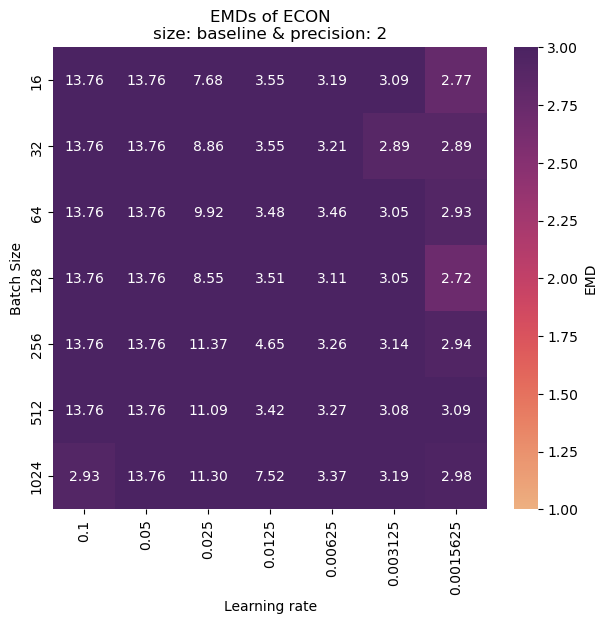

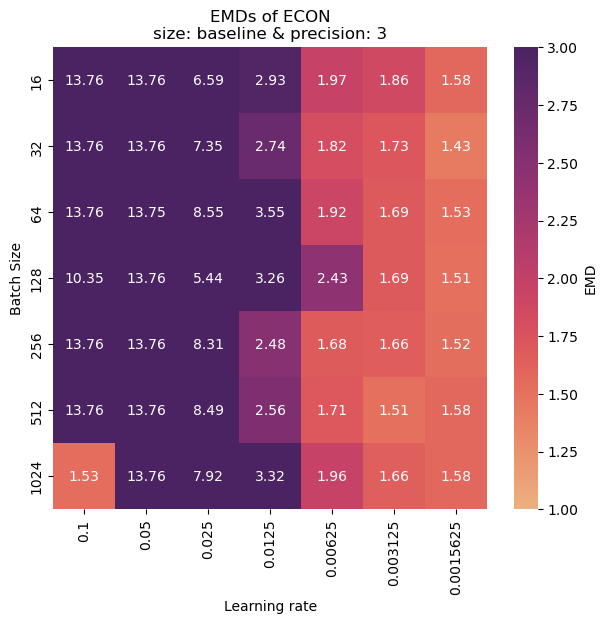

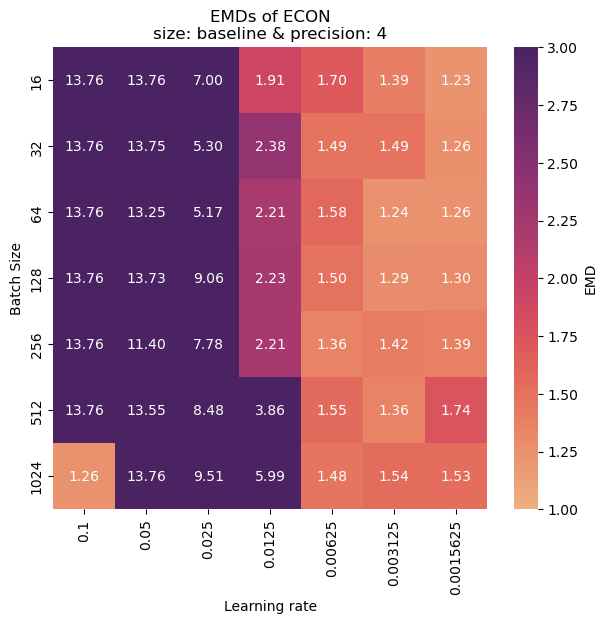

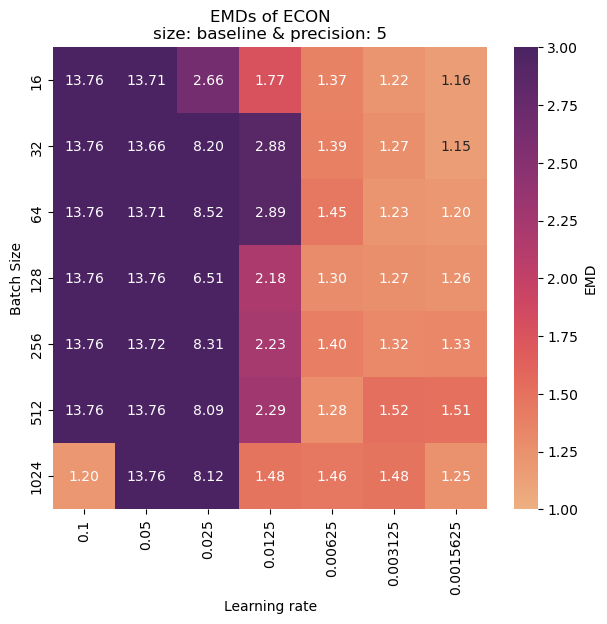

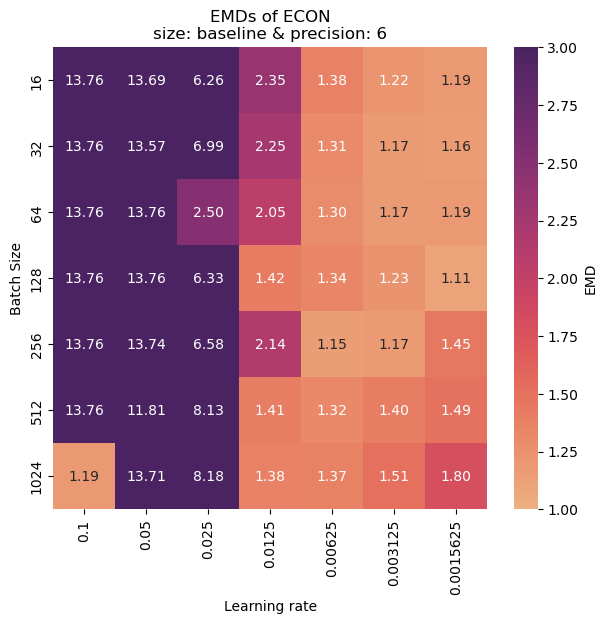

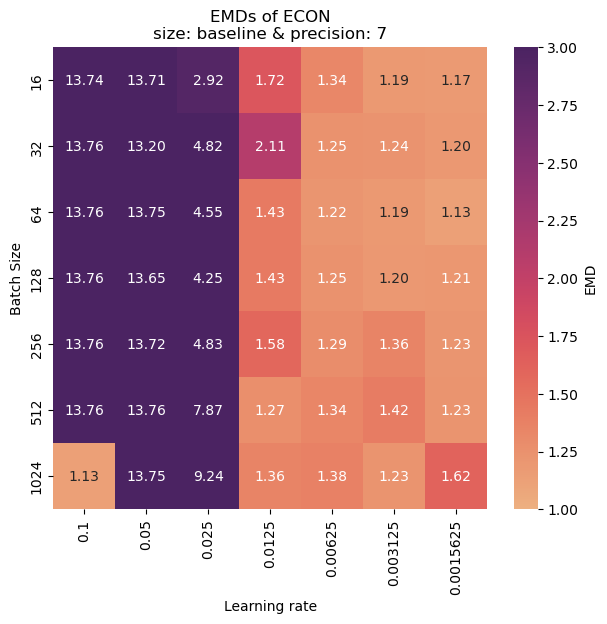

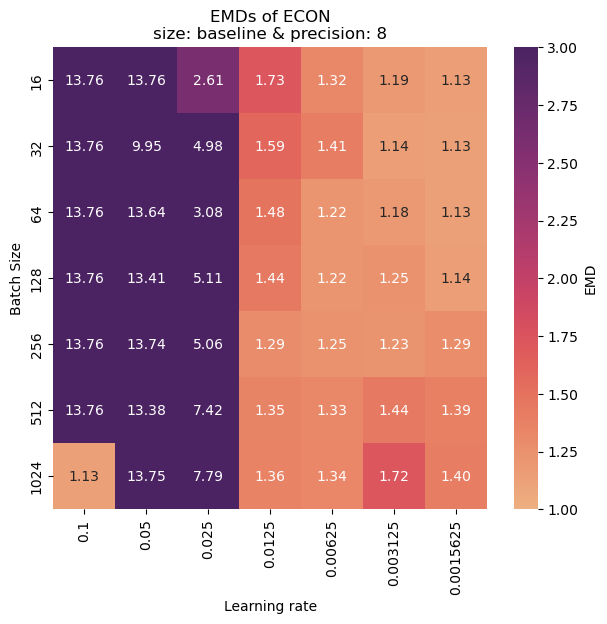

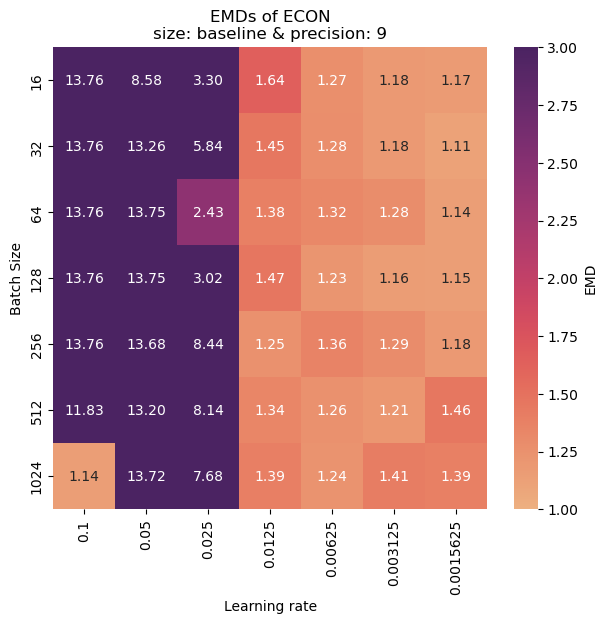

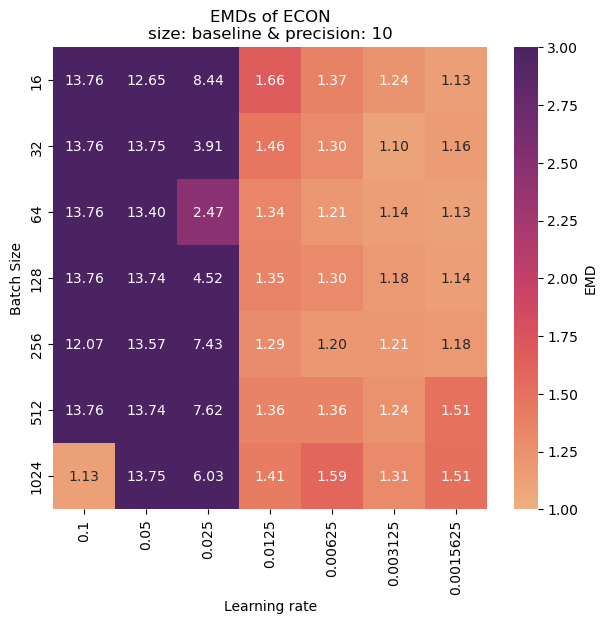

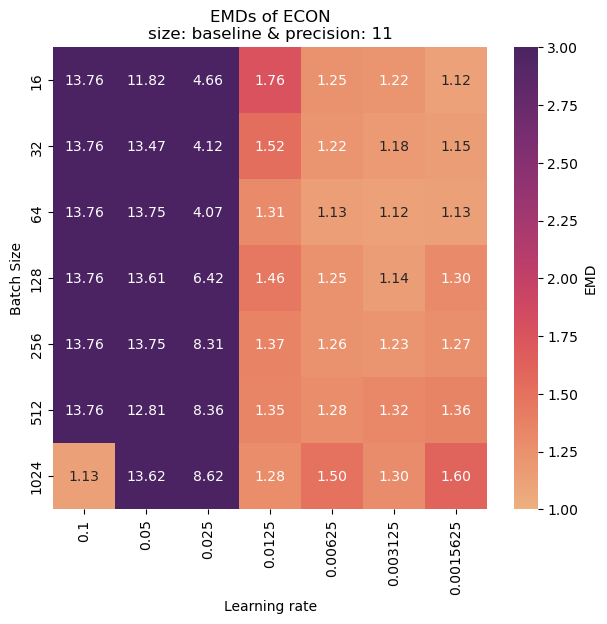

In [79]:
# plotting a heat map per layer
for p in precisions:
    EMD_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            mean_EMD, _ = get_model_index_and_relative_EMD(bs, lr, p, size)
            EMD_matrix[x, y] = mean_EMD
            
            
    EMD_matrix = pd.DataFrame(EMD_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    
    plot_2d_heatmap(EMD_matrix, 
                    f'EMDs of ECON\nsize: {size} & precision: {p}', 
                    (1, 3),
                    'Learning rate',
                    'Batch Size',
                    'EMD',
                    cmap='flare')

Let's remove high learning rates from next analysis:

In [80]:
learning_rates = [0.025, 0.0125, 0.00625, 0.003125, 0.0015625]

In [81]:
emd_distribution = []
for p in precisions:
    EMD_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            mean_EMD, _ = get_model_index_and_relative_EMD(bs, lr, p, size)
            EMD_matrix[x, y] = mean_EMD
            emd_distribution.append({
                'precision': p, 
                'EMD': mean_EMD,
                'batch_size': str(bs),
                'learning_rate': str(lr),
            })

In [82]:
emd_distribution_df = pd.DataFrame(emd_distribution)
emd_distribution_df = emd_distribution_df.sort_values(by='EMD', ascending=True)
emd_distribution_df.head(10)

precision       EMD batch_size learning_rate
288         10  1.104643         32      0.003125
159          6  1.105781        128     0.0015625
254          9  1.114145         32     0.0015625
319         11  1.120972         16     0.0015625
328         11  1.123161         64      0.003125
294         10  1.126236         64     0.0015625
219          8  1.127017         32     0.0015625
329         11  1.127617         64     0.0015625
224          8  1.127975         64     0.0015625
189          7  1.132471         64     0.0015625

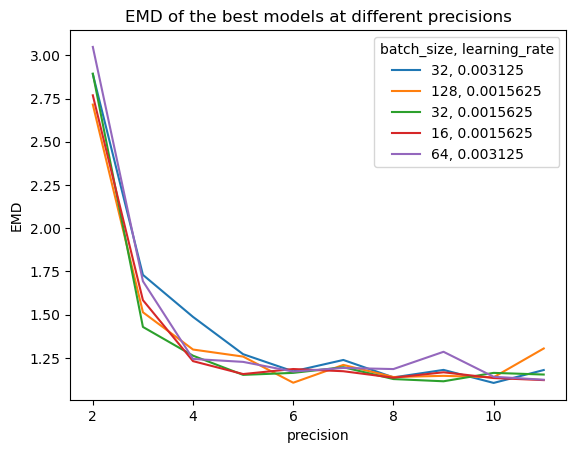

In [83]:
top_5_df = emd_distribution_df.loc[
    (emd_distribution_df.batch_size == '32') & (emd_distribution_df.learning_rate == '0.003125') |
    (emd_distribution_df.batch_size == '128') & (emd_distribution_df.learning_rate == '0.0015625') |
    (emd_distribution_df.batch_size == '32') & (emd_distribution_df.learning_rate == '0.0015625') |
    (emd_distribution_df.batch_size == '16') & (emd_distribution_df.learning_rate == '0.0015625') |
    (emd_distribution_df.batch_size == '64') & (emd_distribution_df.learning_rate == '0.003125')
    ]

hue = top_5_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_5_df, x='precision', y='EMD', hue=hue)
plt.title("EMD of the best models at different precisions")
plt.show()

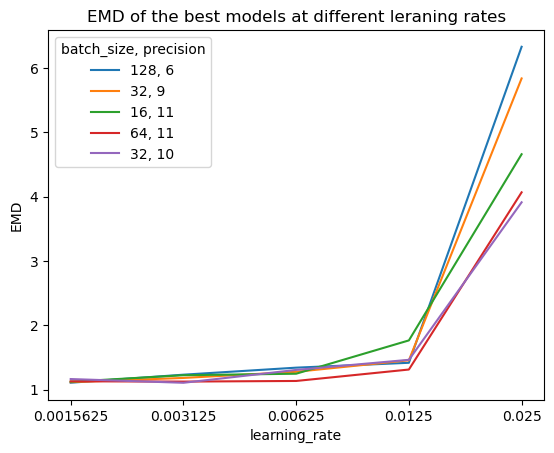

In [84]:
top_5_df = emd_distribution_df.loc[
    (emd_distribution_df.batch_size == '32') & (emd_distribution_df.precision == 10) |
    (emd_distribution_df.batch_size == '128') & (emd_distribution_df.precision == 6) |
    (emd_distribution_df.batch_size == '32') & (emd_distribution_df.precision == 9) |
    (emd_distribution_df.batch_size == '16') & (emd_distribution_df.precision == 11) |
    (emd_distribution_df.batch_size == '64') & (emd_distribution_df.precision == 11)
    ]

top_5_df = top_5_df.sort_values(by='learning_rate', ascending=True)

hue = top_5_df[['batch_size', 'precision']] \
        .apply(lambda row: f"{row.batch_size}, {row.precision}", axis=1)
hue.name = 'batch_size, precision'

sns.lineplot(top_5_df, x='learning_rate', y='EMD', hue=hue)
plt.title("EMD of the best models at different leraning rates")
plt.show()

## Scientific Benchmark

In [85]:
def get_emd_with_noise(batch_size, learning_rate, precision, size, noise_type, percentage):
    '''
    Return the EMD achieved by the Model with a certain level of noise
    '''

    file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                f'ECON_{precision}b/{size}/{size}_emd_{noise_type}_{percentage}.txt'
    noise_emd = -1
    try:
        emd_file = open(file_path)
        emd_text = emd_file.read()
        if not emd_text.startswith('['):
            noise_emd = float(emd_text)
        else:
            emd = ast.literal_eval(emd_text)
            noise_emd = emd[0]['AVG_EMD']
        emd_file.close()
    except Exception as e:
        # warnings.warn("Warning: " + file_path + " not found!")
        return -1
    return noise_emd

Discard the extreme low precision because of its performance

In [86]:
precisions = [3, 4, 5, 6, 7, 8, 9, 10, 11]
noise_type = 'gaussian'

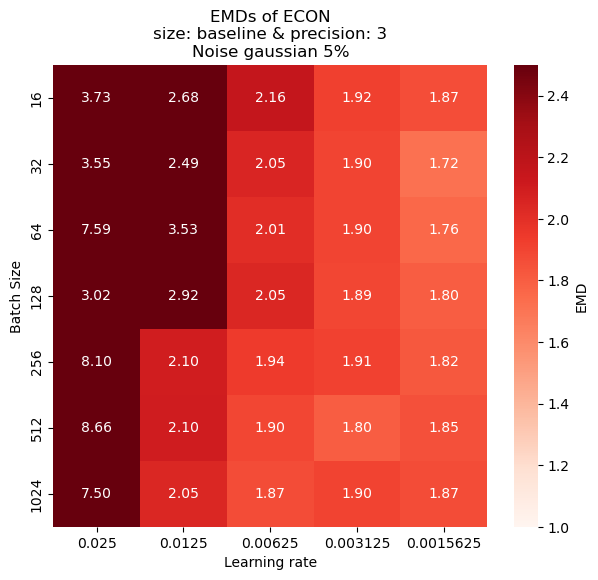

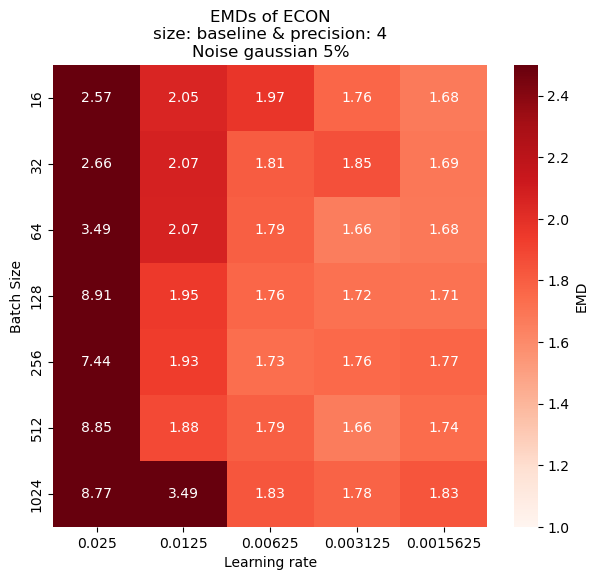

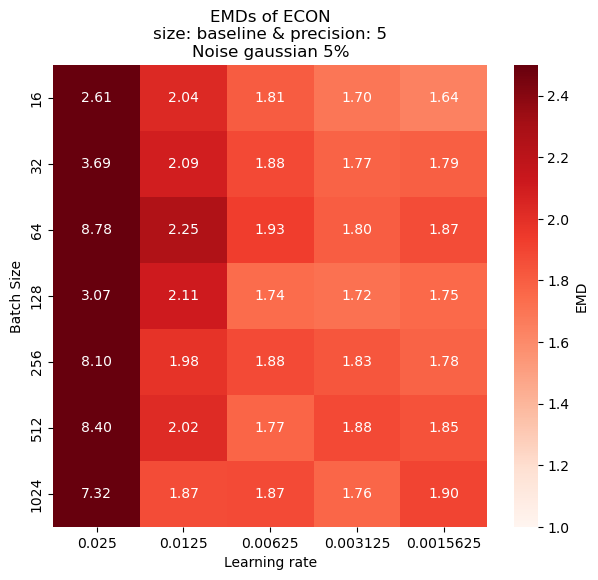

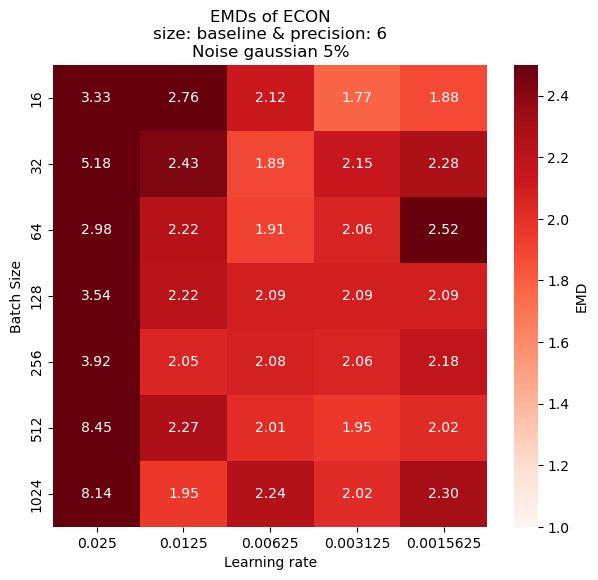

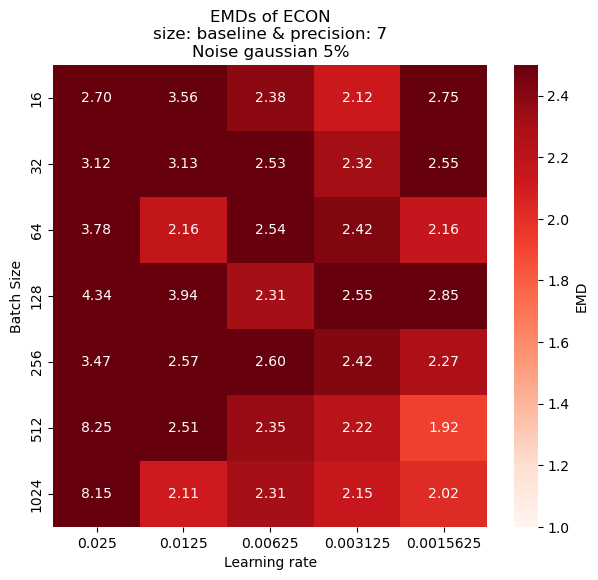

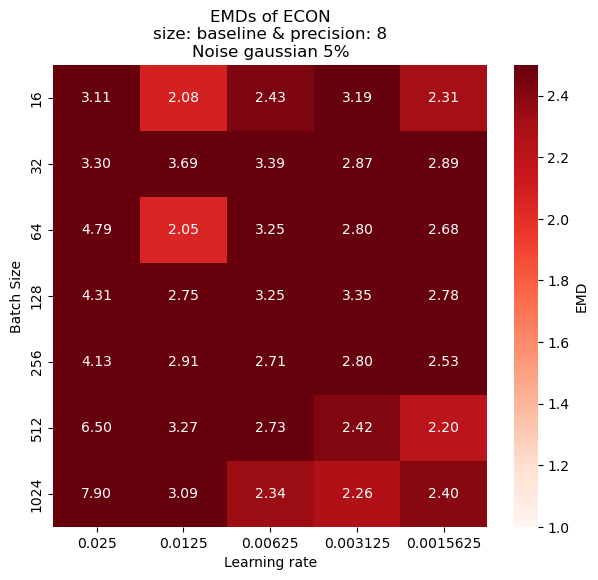

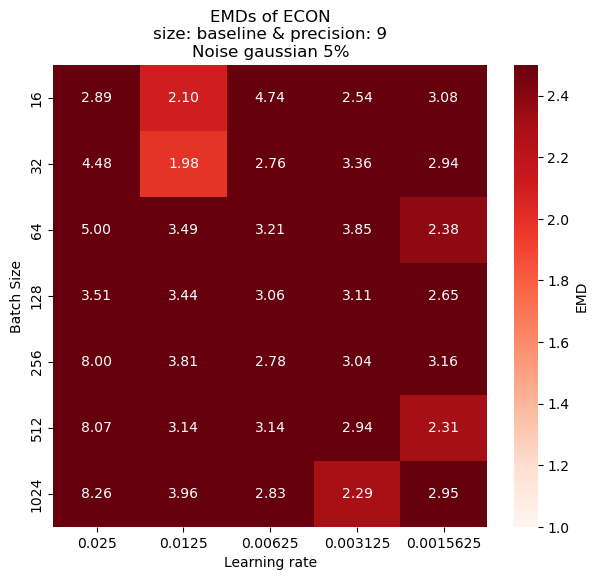

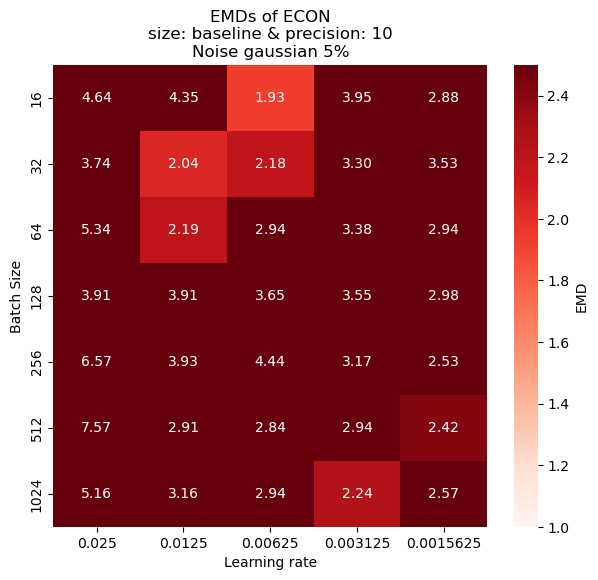

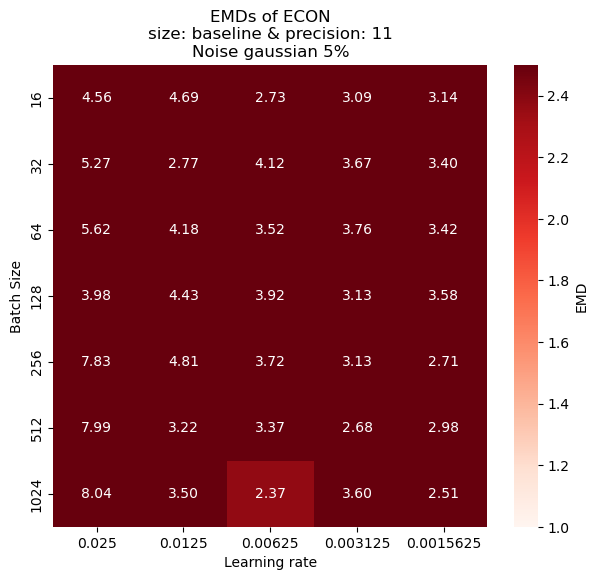

In [94]:
emd_distribution = []
for p in precisions:
    EMD_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            # get teh noise values
            noise_emd_5 = get_emd_with_noise(bs, lr, p, size, noise_type, 5)
            noise_emd_10 = get_emd_with_noise(bs, lr, p, size, noise_type, 10)
            noise_emd_15 = get_emd_with_noise(bs, lr, p, size, noise_type, 15)
            noise_emd_20 = get_emd_with_noise(bs, lr, p, size, noise_type, 20)
            original_emd, _ = get_model_index_and_relative_EMD(bs, lr, p, size)
            
            # build the matrix for the heatmap
            EMD_matrix[x, y] = noise_emd_5
            
            # store the values for the plots
            emd_distribution.append({
                'precision': p, 
                'emd': original_emd,
                'type': 'original',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': p,
                'loss': 0
            })
            emd_distribution.append({
                'precision': p, 
                'emd': noise_emd_5,
                'type': '5%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': p,
                'loss': (noise_emd_5 - original_emd) * 100 / original_emd,
                'original_emd': original_emd
            })
            emd_distribution.append({
                'precision': p, 
                'emd': noise_emd_10,
                'type': '10%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': p,
                'loss': (noise_emd_10 - original_emd) * 100 / original_emd,
                'original_emd': original_emd
            })
            emd_distribution.append({
                'precision': p, 
                'emd': noise_emd_15,
                'type': '15%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': p,
                'loss': (noise_emd_15 - original_emd) * 100 / original_emd,
                'original_emd': original_emd
            })
            emd_distribution.append({
                'precision': p, 
                'emd': noise_emd_20,
                'type': '20%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': p,
                'loss': (noise_emd_20 - original_emd) * 100 / original_emd,
                'original_emd': original_emd
            })
            
            
            
    # heat map of the EMD with noise as input per precision
    EMD_matrix = pd.DataFrame(EMD_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    
    plot_2d_heatmap(EMD_matrix, 
                    f'EMDs of ECON\nsize: {size} & precision: {p}\n' \
                    f'Noise {noise_type} 5%', 
                    (1, 2.5),
                    'Learning rate',
                    'Batch Size',
                    'EMD',
                    cmap='Reds')
        

In [95]:
emd_distribution_df = pd.DataFrame(emd_distribution)
emd_distribution_df = emd_distribution_df.loc[emd_distribution_df.emd > 0]

In [96]:
noise = 5 # 5 10 15 20
top_noise_df = emd_distribution_df.loc[emd_distribution_df.type == f'{noise}%']
top_noise_df = top_noise_df.sort_values(by='original_emd', ascending=True)
top_noise_df.head(10)

precision       emd type batch_size learning_rate        loss  \
1266         10  3.299116   5%         32      0.003125  198.658953   
621           6  2.093310   5%        128     0.0015625   89.305970   
1096          9  2.935274   5%         32     0.0015625  163.455287   
1421         11  3.136834   5%         16     0.0015625  179.831705   
1466         11  3.757545   5%         64      0.003125  234.550832   
1296         10  2.940475   5%         64     0.0015625  161.088665   
921           8  2.894459   5%         32     0.0015625  156.824785   
1471         11  3.419063   5%         64     0.0015625  203.211435   
946           8  2.683540   5%         64     0.0015625  137.907868   
771           7  2.156388   5%         64     0.0015625   90.414483   

      original_emd  
1266      1.104643  
621       1.105781  
1096      1.114145  
1421      1.120972  
1466      1.123161  
1296      1.126236  
921       1.127017  
1471      1.127617  
946       1.127975  
771       1.132471

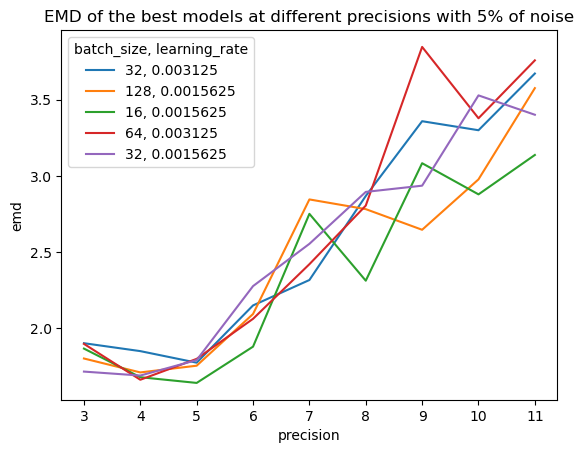

In [97]:
top_noise_df = top_noise_df.loc[
    (top_noise_df.batch_size == '32') & (top_noise_df.learning_rate == '0.003125') |
    (top_noise_df.batch_size == '128') & (top_noise_df.learning_rate == '0.0015625') |
    (top_noise_df.batch_size == '32') & (top_noise_df.learning_rate == '0.0015625') |
    (top_noise_df.batch_size == '16') & (top_noise_df.learning_rate == '0.0015625') |
    (top_noise_df.batch_size == '64') & (top_noise_df.learning_rate == '0.003125')
    ]

top_noise_df = top_noise_df.sort_values(by='precision', ascending=False)

hue = top_noise_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_noise_df, x='precision', y='emd', hue=hue, orient="x")
plt.title(f"EMD of the best models at different precisions with {noise}% of noise")
plt.show()

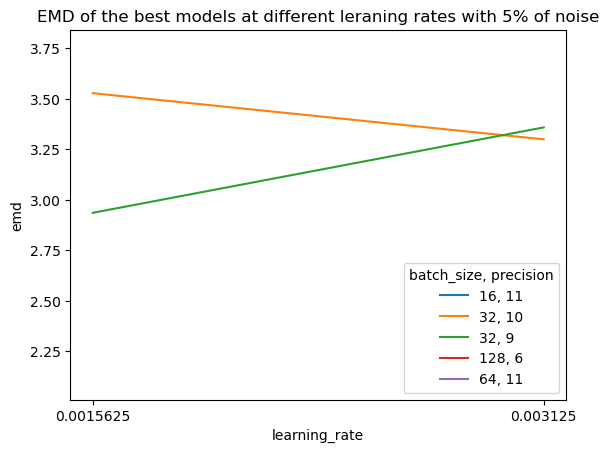

In [98]:
top_noise_df = top_noise_df.loc[
    (top_noise_df.batch_size == '32') & (top_noise_df.precision == 10) |
    (top_noise_df.batch_size == '128') & (top_noise_df.precision == 6) |
    (top_noise_df.batch_size == '32') & (top_noise_df.precision == 9) |
    (top_noise_df.batch_size == '16') & (top_noise_df.precision == 11) |
    (top_noise_df.batch_size == '64') & (top_noise_df.precision == 11)
    ]

top_noise_df = top_noise_df.sort_values(by='learning_rate', ascending=True)

hue = top_noise_df[['batch_size', 'precision']] \
        .apply(lambda row: f"{row.batch_size}, {row.precision}", axis=1)
hue.name = 'batch_size, precision'

sns.lineplot(top_noise_df, x='learning_rate', y='emd', hue=hue)
plt.title(f"EMD of the best models at different leraning rates with {noise}% of noise")
plt.show()

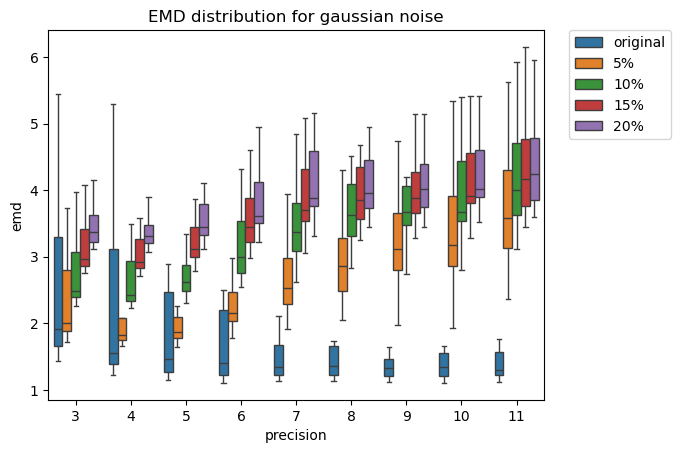

In [99]:
sns.boxplot(data=emd_distribution_df, 
            x='precision', 
            y='emd',
            hue='type',
            showfliers=False)

plt.title(f'EMD distribution for {noise_type} noise')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

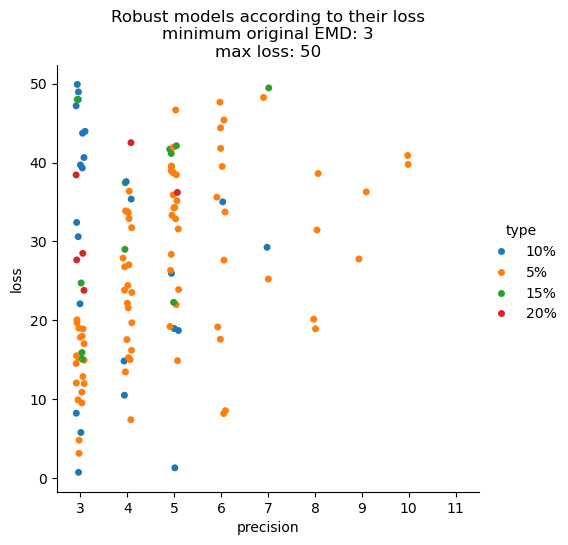

In [100]:
MAX_LOSS = 50
MAX_EMD = 3
# filter the entries 
robust_df = emd_distribution_df.sort_values(by=['loss', 'original_emd'], ascending=[True, True])
robust_df = robust_df.drop(robust_df[robust_df.type == 'original'].index)
robust_df = robust_df.drop(robust_df[(robust_df.loss < 0) | (robust_df.loss > MAX_LOSS)].index)
robust_df = robust_df.drop(robust_df[robust_df.original_emd > MAX_EMD].index)

sns.catplot(robust_df, y='loss', x='precision', hue='type', order=precisions)
plt.title(f'Robust models according to their loss\n' \
          f'minimum original EMD: {MAX_EMD}\n' \
          f'max loss: {MAX_LOSS}')
plt.show()

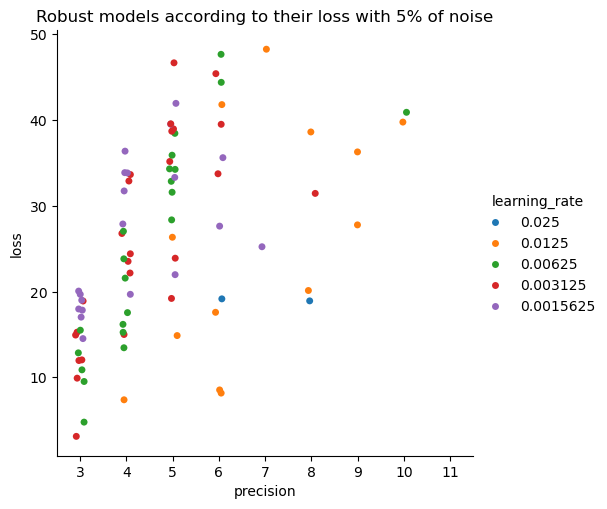

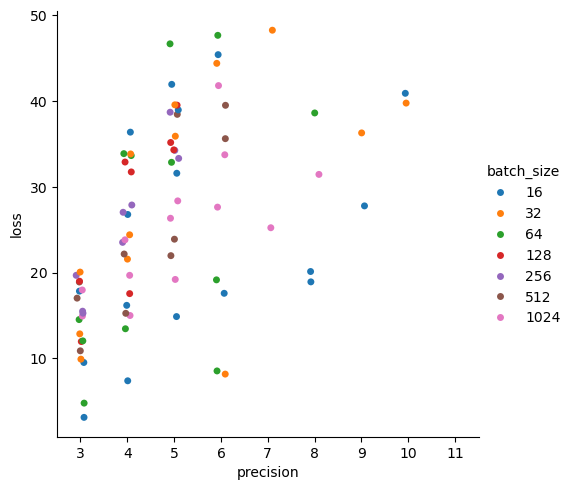

   original_emd       loss batch_size learning_rate  precision
0      1.860878   3.138007         16      0.003125          3
1      1.919065   4.798361         64       0.00625          3
2      1.910940   7.400822         16        0.0125          4
3      2.245751   8.182710         32        0.0125          6
4      2.049524   8.550996         64        0.0125          6
5      1.967709   9.534754         16       0.00625          3
6      1.729949   9.922525         32      0.003125          3
7      1.709671  10.893808        512       0.00625          3
8      1.691347  11.978386        128      0.003125          3
9      1.693192  12.054004         64      0.003125          3
    original_emd       loss batch_size learning_rate  precision
72      1.270912  39.569528         32      0.003125          5
73      1.461834  39.771948         32        0.0125         10
74      1.369688  40.912487         16       0.00625         10
75      1.376757  41.811120       1024        0.012

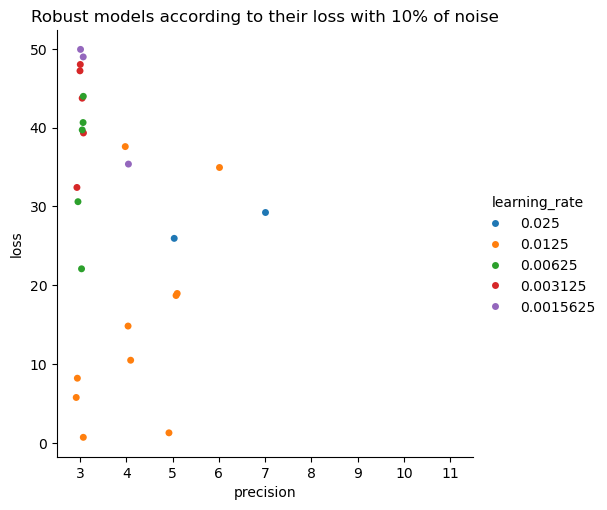

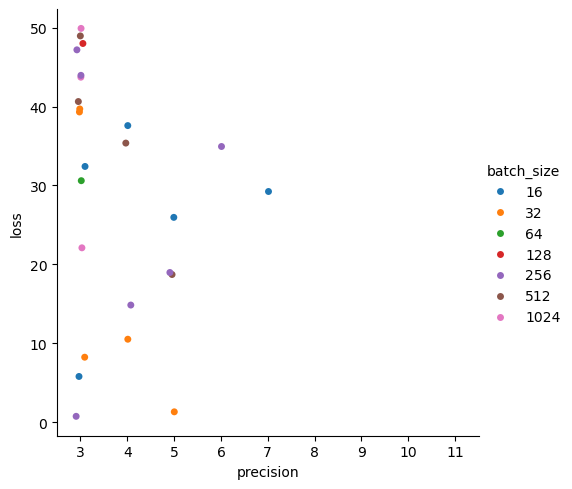

   original_emd       loss batch_size learning_rate  precision
0      2.479948   0.726937        256        0.0125          3
1      2.876875   1.297771         32        0.0125          5
2      2.931284   5.781862         16        0.0125          3
3      2.738463   8.224824         32        0.0125          3
4      2.375551  10.505084         32        0.0125          4
5      2.214235  14.838048        256        0.0125          4
6      2.285544  18.711903        512        0.0125          5
7      2.234362  18.968007        256        0.0125          5
8      1.958069  22.097315       1024       0.00625          3
9      2.655157  25.959411         16         0.025          5
    original_emd       loss batch_size learning_rate  precision
15      1.910940  37.597840         16        0.0125          4
16      1.729949  39.325586         32      0.003125          3
17      1.817719  39.710422         32       0.00625          3
18      1.709671  40.648277        512       0.0062

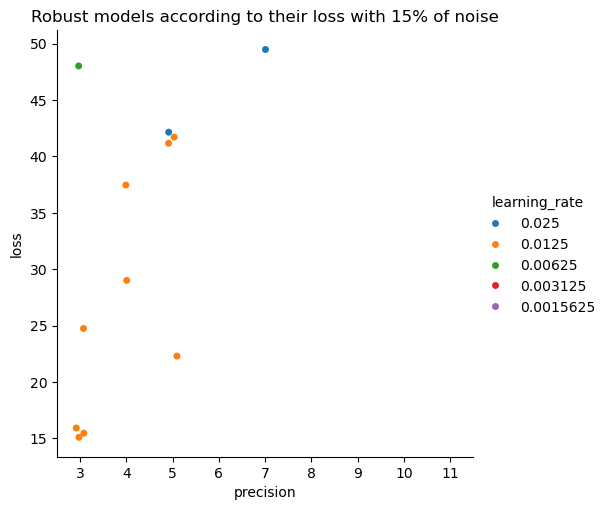

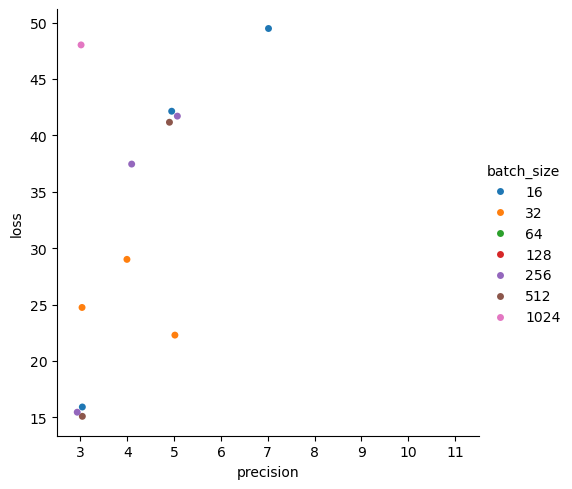

   original_emd       loss batch_size learning_rate  precision
0      2.559708  15.090062        512        0.0125          3
1      2.479948  15.456090        256        0.0125          3
2      2.931284  15.917443         16        0.0125          3
3      2.876875  22.290658         32        0.0125          5
4      2.738463  24.741362         32        0.0125          3
5      2.375551  29.005498         32        0.0125          4
6      2.214235  37.454511        256        0.0125          4
7      2.285544  41.161782        512        0.0125          5
8      2.234362  41.704766        256        0.0125          5
9      2.655157  42.139292         16         0.025          5
    original_emd       loss batch_size learning_rate  precision
2       2.931284  15.917443         16        0.0125          3
3       2.876875  22.290658         32        0.0125          5
4       2.738463  24.741362         32        0.0125          3
5       2.375551  29.005498         32        0.012

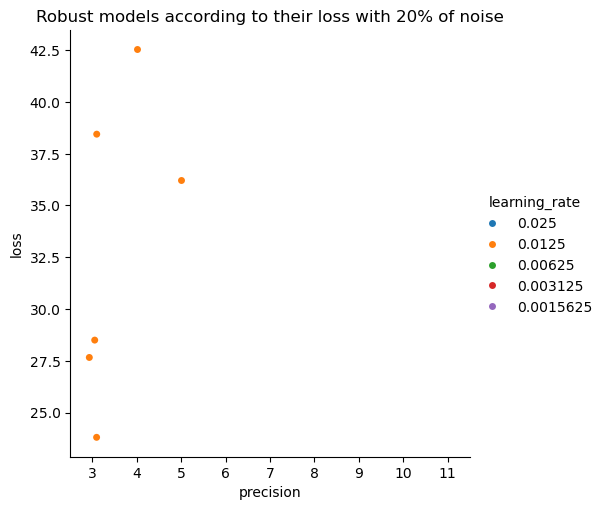

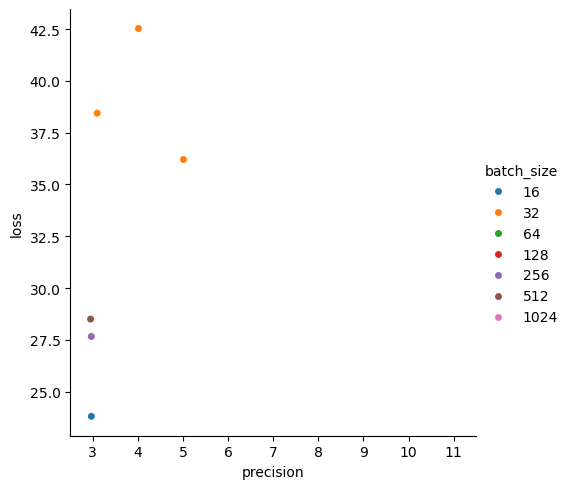

   original_emd       loss batch_size learning_rate  precision
0      2.931284  23.806723         16        0.0125          3
1      2.479948  27.662769        256        0.0125          3
2      2.559708  28.500830        512        0.0125          3
3      2.876875  36.220181         32        0.0125          5
4      2.738463  38.444167         32        0.0125          3
5      2.375551  42.537106         32        0.0125          4
   original_emd       loss batch_size learning_rate  precision
0      2.931284  23.806723         16        0.0125          3
1      2.479948  27.662769        256        0.0125          3
2      2.559708  28.500830        512        0.0125          3
3      2.876875  36.220181         32        0.0125          5
4      2.738463  38.444167         32        0.0125          3
5      2.375551  42.537106         32        0.0125          4


In [101]:
noise_levels = [5, 10, 15, 20]
for noise in noise_levels:
    # Check the most robust models per noise
    df = robust_df.drop(robust_df[robust_df.type != f'{noise}%'].index)
    df = df.reset_index()
    
    sns.catplot(df, 
                x='precision', 
                y='loss', 
                hue='learning_rate', 
                order=precisions, 
                hue_order=[str(x) for x in learning_rates])
    plt.title(f'Robust models according to their loss with {noise}% of noise')
    sns.catplot(df, 
                x='precision', 
                y='loss', 
                hue='batch_size', 
                order=precisions, 
                hue_order=[str(x) for x in batch_sizes])
    plt.show()
    print(df[['original_emd', 'loss', 'batch_size', 'learning_rate', 'precision']].head(10))
    print(df[['original_emd', 'loss', 'batch_size', 'learning_rate', 'precision']].tail(10))
    df.to_csv(f"./out{noise}_{noise_type}.csv")

In [102]:
noise = 5 # 5 10 15 20
top_noise_df = robust_df.loc[robust_df.type == f'{noise}%']
top_noise_df = top_noise_df.sort_values(by='loss', ascending=True)
top_noise_df = top_noise_df.reset_index()
top_noise_df.head(5)

index  precision       emd type batch_size learning_rate      loss  \
0     16          3  1.919272   5%         16      0.003125  3.138007   
1     61          3  2.011148   5%         64       0.00625  4.798361   
2    181          4  2.052365   5%         16        0.0125  7.400822   
3    556          6  2.429515   5%         32        0.0125  8.182710   
4    581          6  2.224779   5%         64        0.0125  8.550996   

   original_emd  
0      1.860878  
1      1.919065  
2      1.910940  
3      2.245751  
4      2.049524

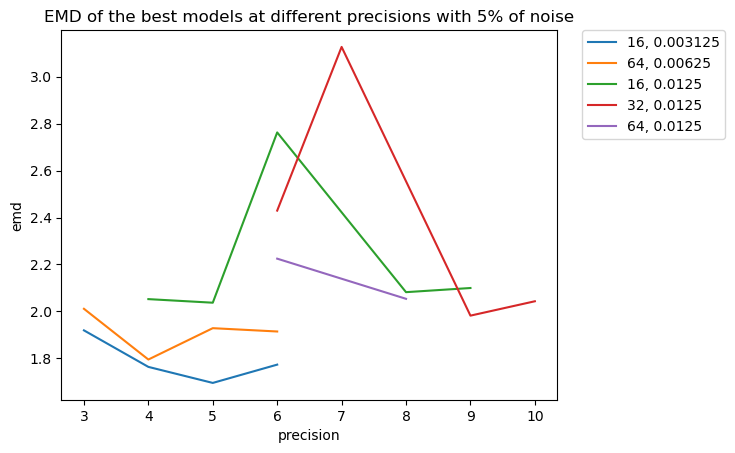

In [104]:
top_noise_df = top_noise_df.loc[
        (top_noise_df.batch_size == '16') & (top_noise_df.learning_rate == '0.003125') |
        (top_noise_df.batch_size == '64') & (top_noise_df.learning_rate == '0.00625') |
        (top_noise_df.batch_size == '16') & (top_noise_df.learning_rate == '0.0125') |
        (top_noise_df.batch_size == '32') & (top_noise_df.learning_rate == '0.0125') |
        (top_noise_df.batch_size == '64') & (top_noise_df.learning_rate == '0.0125')
    ]
hue = top_noise_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_noise_df, x='precision', y='emd', hue=hue)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title(f"EMD of the best models at different precisions with {noise}% of noise")
plt.show()

# Jet Tagger (MLP)
The full precision model achieve 76% of accuracy.

In [4]:
DATA_PATH="/home/jovyan/checkpoint/"    
DATASET_DIR="../../data/JTAG"
DATASET_FILE=DATASET_DIR + "/processed_dataset.h5"

In [5]:
def get_data_module(batch_size, num_workers=12):
    '''
    Method used to get the data modules used during the tests
    '''
    data_module = JetDataModule(
        data_dir=DATASET_DIR,
        data_file=os.path.join(DATASET_DIR, DATASET_FILE),
        batch_size=batch_size,
        num_workers=num_workers)
    
    # checek if we have processed the data
    if not os.path.exists(os.path.join(DATASET_DIR, DATASET_FILE)):
        print('Processing the data...')
        data_module.process_data(save=True)

    data_module.setup(0)
    return data_module


def load_model(batch_size, learning_rate, precision):
    '''
    Method used to get the model and the relative accuracy
    '''
    accuracy, idx = get_model_index_and_relative_accuracy(batch_size, learning_rate, precision)
    model_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/JTAG_{precision}b/net_{idx}_best.pkl'
    
    # load the model
    model = JetTagger(
        quantize=(precision < 32),
        precision=[
            precision,
            precision,
            precision+3
        ],
        learning_rate=learning_rate,
    )
    
    # to set the map location
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model(torch.randn((16, 16)))  # Update tensor shapes 
    model_param = torch.load(model_path, map_location=device)
    model.load_state_dict(model_param['state_dict'])
    
    return model, accuracy


def get_model_index_and_relative_accuracy(batch_size, learning_rate, precision, num_tests=5):
    '''
    Return the average EMDs achieved by the model and the index of best experiment
    '''
    performances = []
    max_acc = 0
    max_acc_index = 0
    for i in range (1, num_tests+1):
        file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                    f'JTAG_{precision}b/accuracy_{i}.txt'
        try:
            jtag_file = open(file_path)
            jtag_text = jtag_file.read()
            accuracy = ast.literal_eval(jtag_text)
            accuracy = accuracy[0]['test_acc']
            performances.append(accuracy)
            if accuracy >= max_acc:
                max_acc = accuracy
                max_acc_index = i
            jtag_file.close()
        except Exception as e:
            # warnings.warn("Warning: " + file_path + " not found!")
            continue
        
    if len(performances) == 0:
        # warnings.warn(f"Attention: There is no accuracy value for the model: " \
        #               f"bs{batch_size}_lr{learning_rate}/JTAG_{precision}b")
        return
    
    return mean(performances), max_acc_index

## Accuracy results

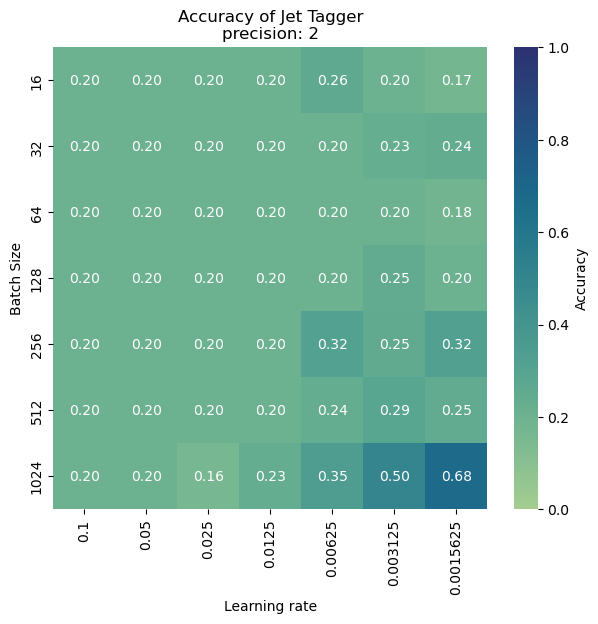

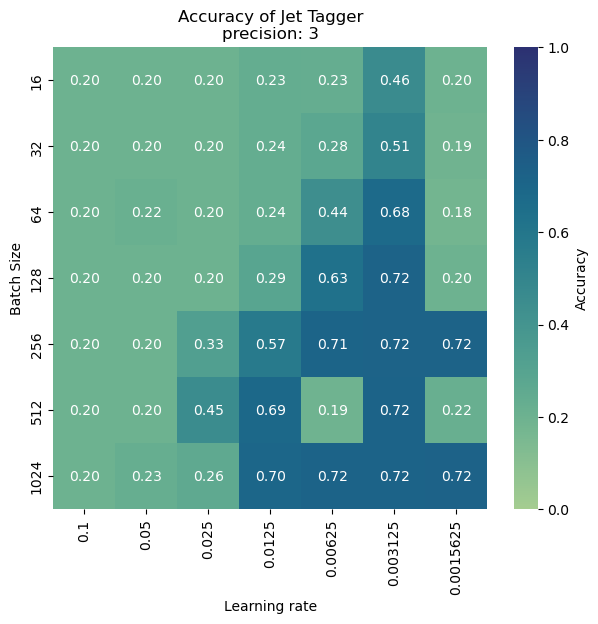

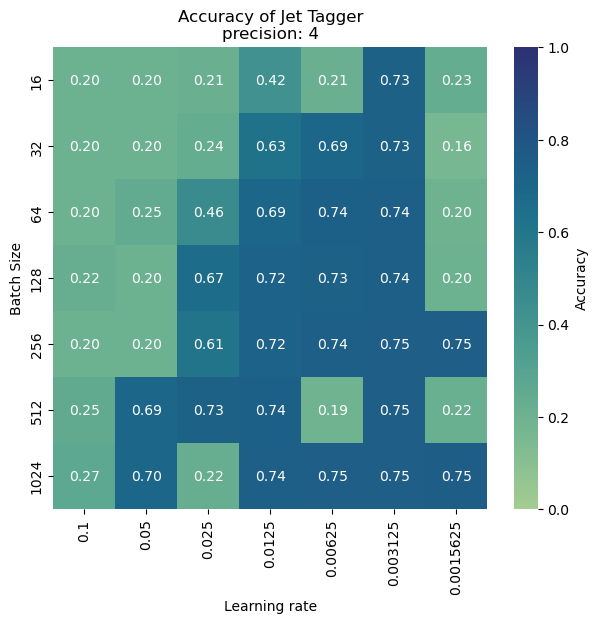

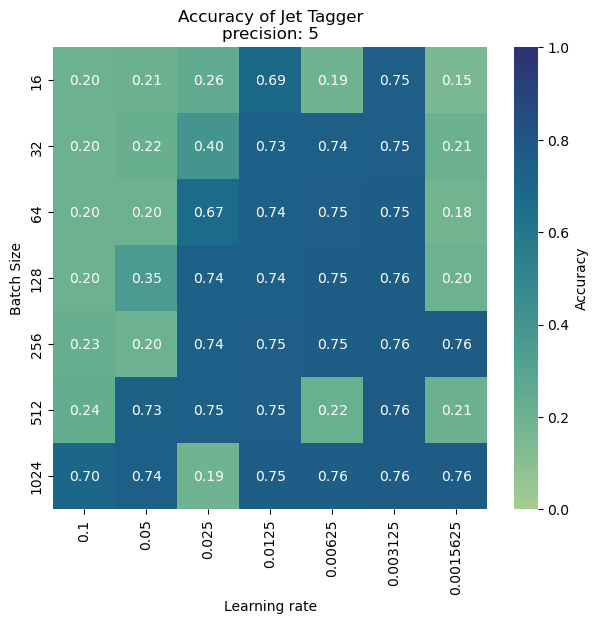

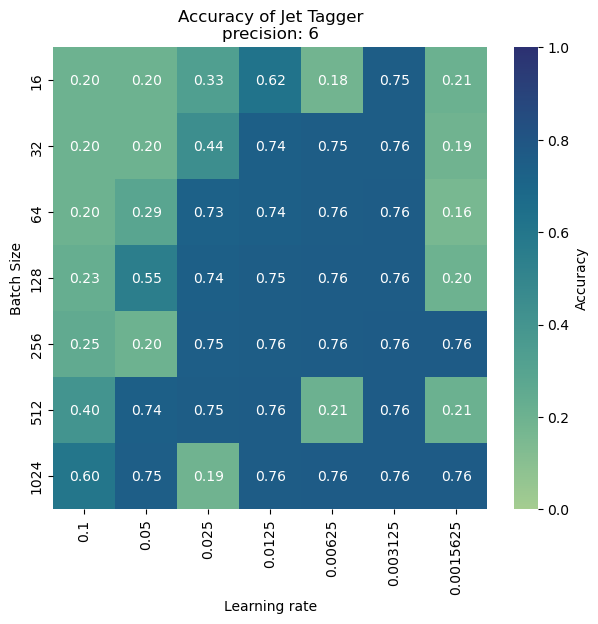

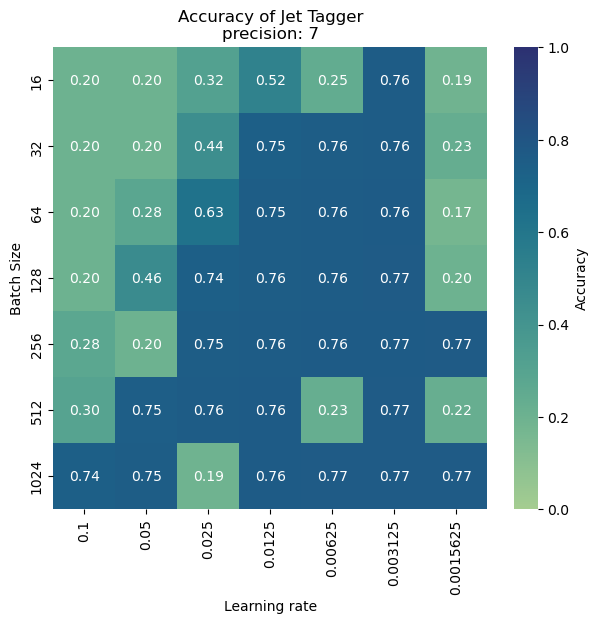

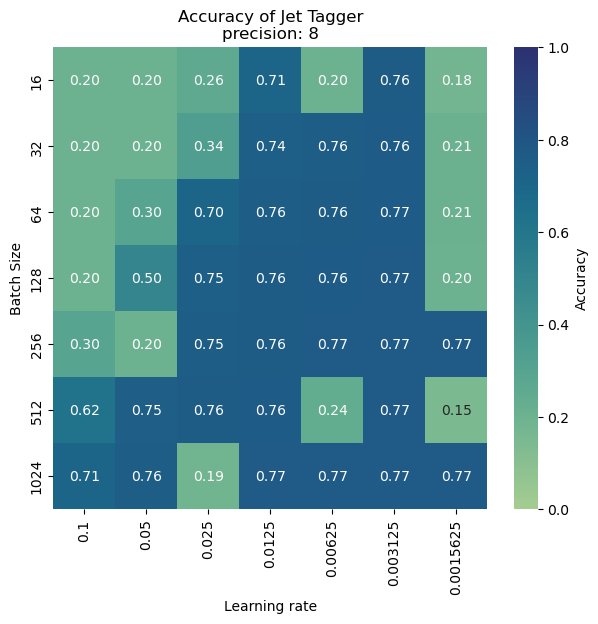

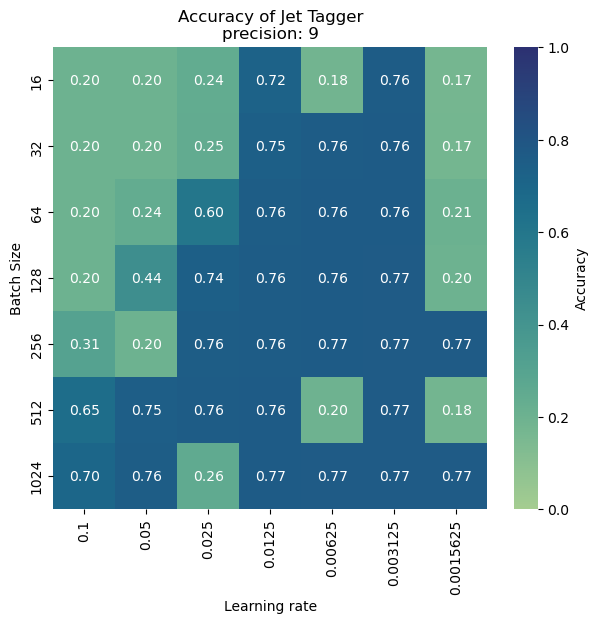

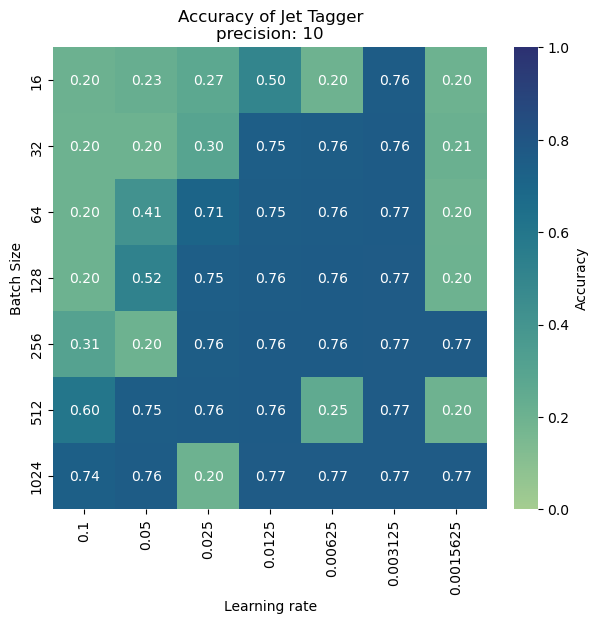

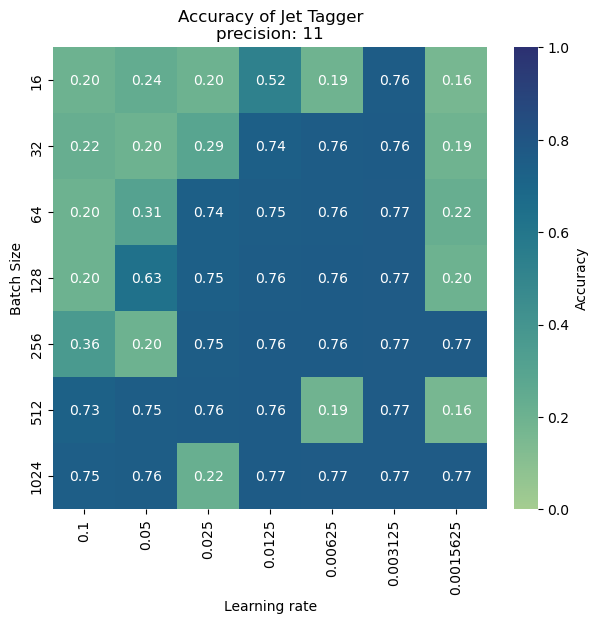

In [68]:
# plotting a heat map per layer
for p in precisions:
    accuracy_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            mean_acc, _ = get_model_index_and_relative_accuracy(bs, lr, p)
            accuracy_matrix[x, y] = mean_acc
            
            
    accuracy_matrix = pd.DataFrame(accuracy_matrix, 
                                   index=batch_sizes, 
                                   columns=learning_rates)
    
    plot_2d_heatmap(accuracy_matrix, 
                    f'Accuracy of Jet Tagger\nprecision: {p}', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'Accuracy',
                    cmap='crest')

In [7]:
acc_distribution = []
for p in precisions:
    acc_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            mean_acc, _ = get_model_index_and_relative_accuracy(bs, lr, p)
            acc_matrix[x, y] = mean_acc
            acc_distribution.append({
                'precision': p, 
                'accuracy': mean_acc,
                'batch_size': str(bs),
                'learning_rate': str(lr)
            })

In [8]:
acc_distribution_df = pd.DataFrame(acc_distribution)
acc_distribution_df = acc_distribution_df.sort_values(by='accuracy', ascending=False)
acc_distribution_df.head(10)

precision  accuracy batch_size learning_rate
489         11  0.768954       1024     0.0015625
426         10  0.768859        256     0.0015625
377          9  0.768732        256     0.0015625
342          8  0.768623       1024     0.0015625
390          9  0.768571       1024      0.003125
391          9  0.768535       1024     0.0015625
475         11  0.768075        256     0.0015625
341          8  0.767931       1024      0.003125
440         10  0.767913       1024     0.0015625
438         10  0.767898       1024       0.00625

let's focus on the top models:

Text(0.5, 1.0, 'Accuracy of the best models at different precisions')

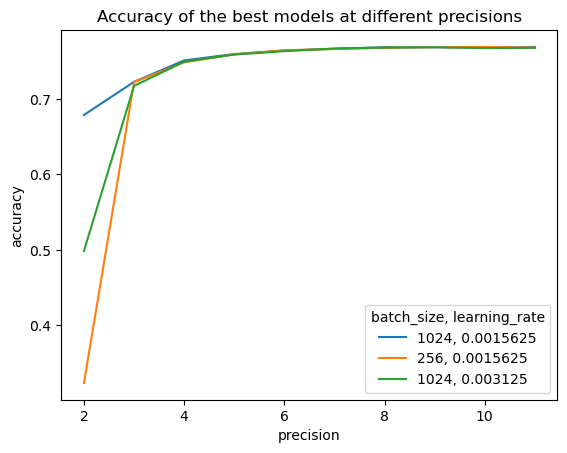

In [11]:
top_5_df = acc_distribution_df.loc[
    (acc_distribution_df.batch_size == '1024') & (acc_distribution_df.learning_rate == '0.0015625') |
    (acc_distribution_df.batch_size == '256') & (acc_distribution_df.learning_rate == '0.0015625') |
    (acc_distribution_df.batch_size == '256') & (acc_distribution_df.learning_rate == '0.0015625') |
    (acc_distribution_df.batch_size == '1024') & (acc_distribution_df.learning_rate == '0.0015625') |
    (acc_distribution_df.batch_size == '1024') & (acc_distribution_df.learning_rate == '0.003125')
    ]

hue = top_5_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_5_df, x='precision', y='accuracy', hue=hue)
plt.title("Accuracy of the best models at different precisions")
plt.show()

Text(0.5, 1.0, 'Accuracy of the best models at different leraning rates')

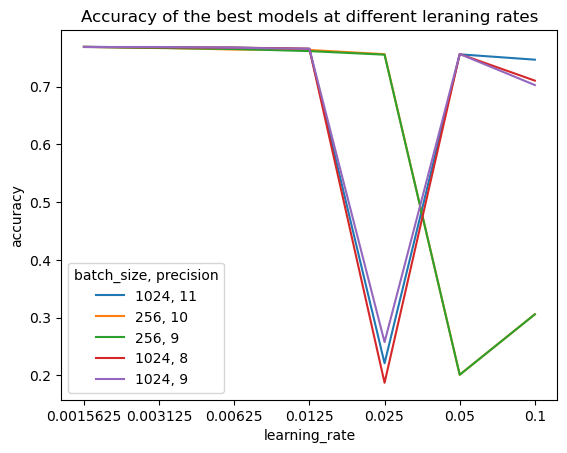

In [12]:
top_5_df = acc_distribution_df.loc[
    (acc_distribution_df.batch_size == '1024') & (acc_distribution_df.precision == 11) |
    (acc_distribution_df.batch_size == '256') & (acc_distribution_df.precision == 10) |
    (acc_distribution_df.batch_size == '256') & (acc_distribution_df.precision == 9) |
    (acc_distribution_df.batch_size == '1024') & (acc_distribution_df.precision == 8) |
    (acc_distribution_df.batch_size == '1024') & (acc_distribution_df.precision == 9)
    ]

top_5_df = top_5_df.sort_values(by='learning_rate', ascending=True)

hue = top_5_df[['batch_size', 'precision']] \
        .apply(lambda row: f"{row.batch_size}, {row.precision}", axis=1)
hue.name = 'batch_size, precision'

sns.lineplot(top_5_df, x='learning_rate', y='accuracy', hue=hue)
plt.title("Accuracy of the best models at different leraning rates")
plt.show()

## Scinetific Benchmark

In [13]:
def get_accuracy_with_noise(batch_size, learning_rate, precision, noise_type, percentage):
    '''
    Return the accuracy achieved by the Model with a certain level of noise
    '''

    file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                f'JTAG_{precision}b/accuracy_{noise_type}_{percentage}.txt'
    noise_acc = -1
    try:
        acc_file = open(file_path)
        acc_text = acc_file.read()
        acc = ast.literal_eval(acc_text)
        noise_acc = acc[0]['test_acc']
        acc_file.close()
    except Exception as e:
        # warnings.warn("Warning: " + file_path + " not found!")
        return 0
    return noise_acc

In [14]:
precisions = [4, 5, 6, 7, 8, 9, 10, 11]
noise_type = 'gaussian'

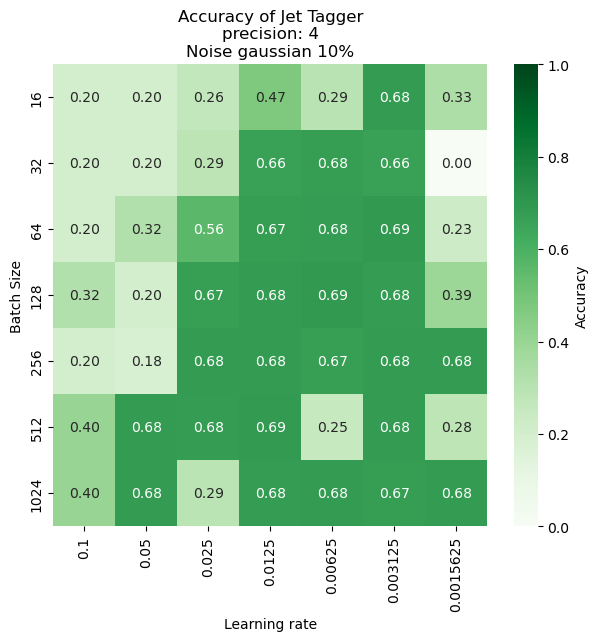

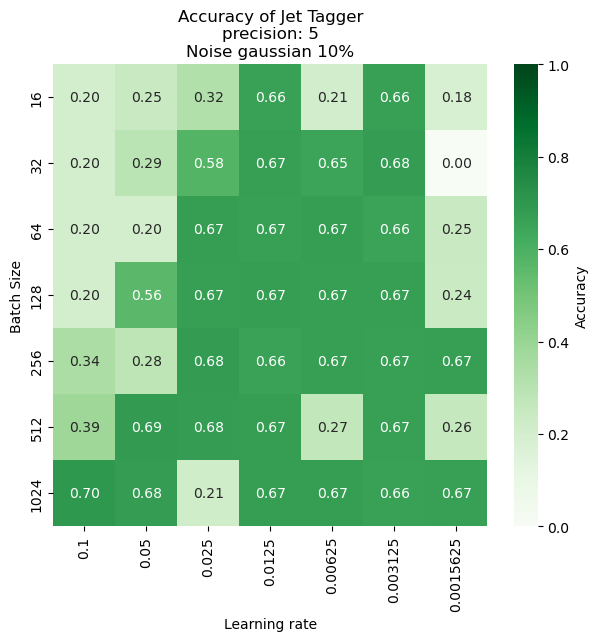

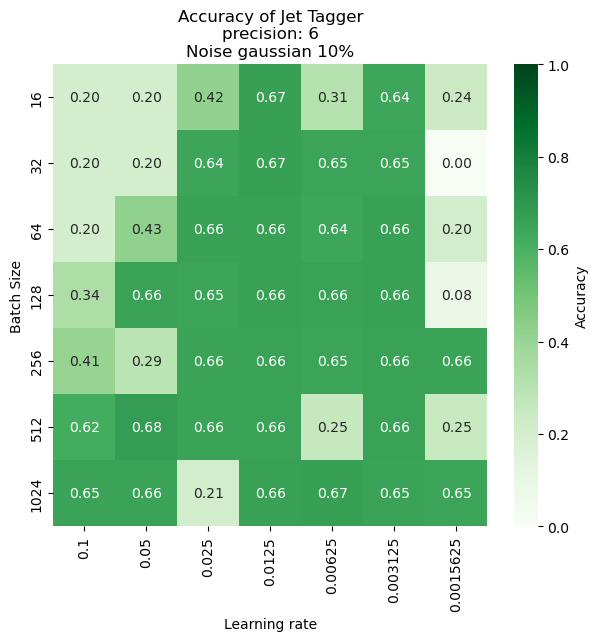

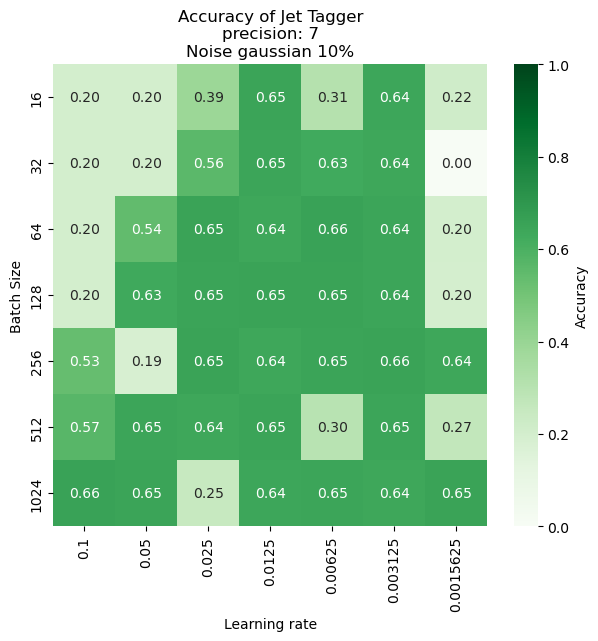

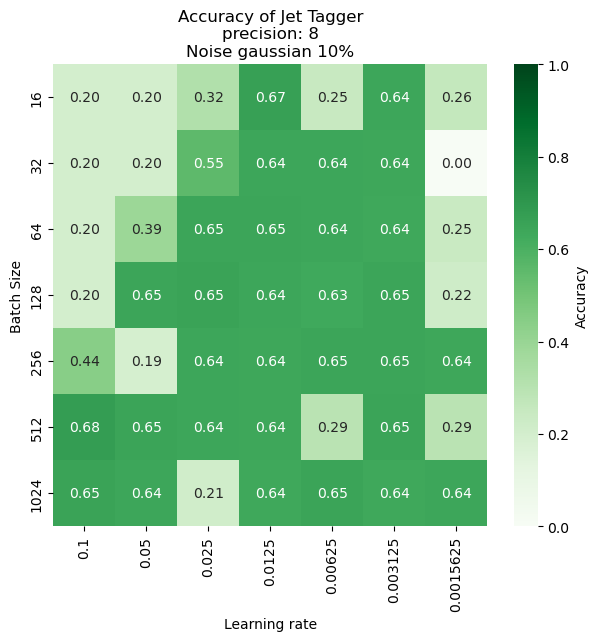

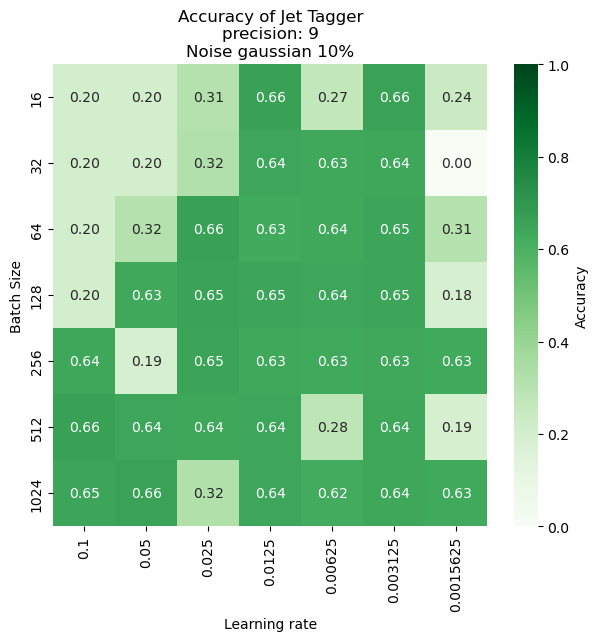

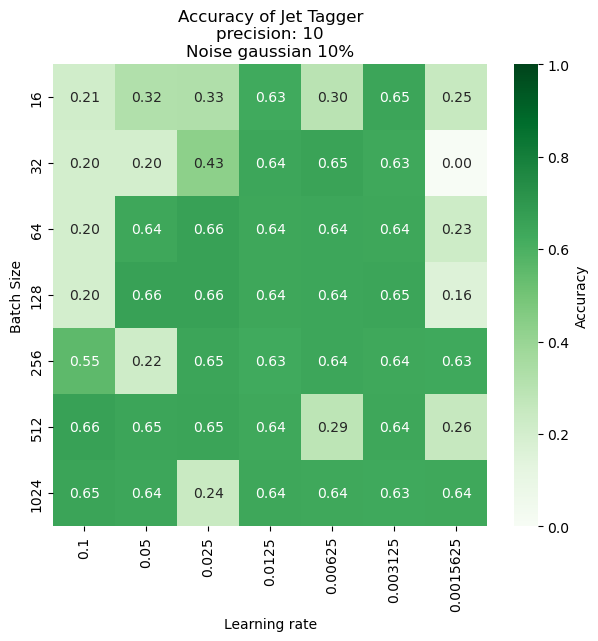

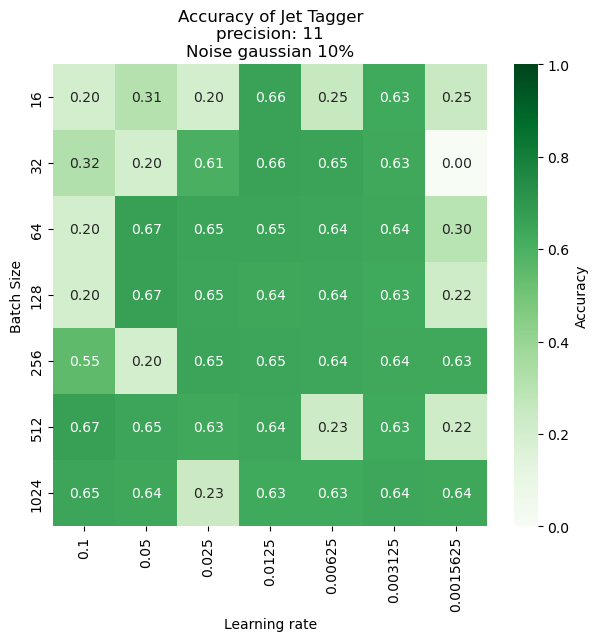

In [16]:
acc_distribution = []
for p in precisions:
    acc_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            # get teh noise values
            noise_acc_20 = get_accuracy_with_noise(bs, lr, p, noise_type, 20)
            noise_acc_15 = get_accuracy_with_noise(bs, lr, p, noise_type, 15)
            noise_acc_10 = get_accuracy_with_noise(bs, lr, p, noise_type, 10)
            noise_acc_5 = get_accuracy_with_noise(bs, lr, p, noise_type, 5)
            original_acc, _ = get_model_index_and_relative_accuracy(bs, lr, p)
            
            # build the matrix for the heatmap
            acc_matrix[x, y] = noise_acc_10
            
            # store the values for the plots
            acc_distribution.append({
                'precision': p, 
                'accuracy': original_acc,
                'type': 'original',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': 0
            })
            acc_distribution.append({
                'precision': p, 
                'accuracy': noise_acc_5,
                'type': '5%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': (original_acc - noise_acc_5) * 100 / original_acc,
                'original_acc': original_acc
            })
            acc_distribution.append({
                'precision': p, 
                'accuracy': noise_acc_10,
                'type': '10%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': (original_acc - noise_acc_10) * 100 / original_acc,
                'original_acc': original_acc
            })
            acc_distribution.append({
                'precision': p, 
                'accuracy': noise_acc_15,
                'type': '15%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': (original_acc - noise_acc_15) * 100 / original_acc,
                'original_acc': original_acc
            })
            acc_distribution.append({
                'precision': p, 
                'accuracy': noise_acc_20,
                'type': '20%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': (original_acc - noise_acc_20) * 100 / original_acc,
                'original_acc': original_acc
            })
            
    # heat map of the accuracy with noise as input per precision
    acc_matrix = pd.DataFrame(acc_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    
    plot_2d_heatmap(acc_matrix, 
                    f'Accuracy of Jet Tagger\nprecision: {p}\n' \
                    f'Noise {noise_type} 10%', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'Accuracy')
        

In [17]:
acc_distribution_df = pd.DataFrame(acc_distribution)
acc_distribution_df = acc_distribution_df.loc[acc_distribution_df.loss > 0]

In [22]:
noise = 5 # 5 10 15 20
top_noise_df = acc_distribution_df.loc[acc_distribution_df.type == f'{noise}%']
top_noise_df = top_noise_df.sort_values(by='original_acc', ascending=False)
top_noise_df.head(10)

precision  accuracy type batch_size learning_rate      loss  \
1956         11  0.727083   5%       1024     0.0015625  5.445168   
1641         10  0.725321   5%        256     0.0015625  5.662720   
1396          9  0.723229   5%        256     0.0015625  5.919164   
1221          8  0.728612   5%       1024     0.0015625  5.205419   
1461          9  0.726721   5%       1024      0.003125  5.445175   
1466          9  0.724275   5%       1024     0.0015625  5.759008   
1886         11  0.726504   5%        256     0.0015625  5.412345   
1216          8  0.726375   5%       1024      0.003125  5.411406   
1711         10  0.727500   5%       1024     0.0015625  5.262743   
1701         10  0.725217   5%       1024       0.00625  5.558240   

      original_acc  
1956      0.768954  
1641      0.768859  
1396      0.768732  
1221      0.768623  
1461      0.768571  
1466      0.768535  
1886      0.768075  
1216      0.767931  
1711      0.767913  
1701      0.767898

Let's see how the previous top 5 models perform with noise:

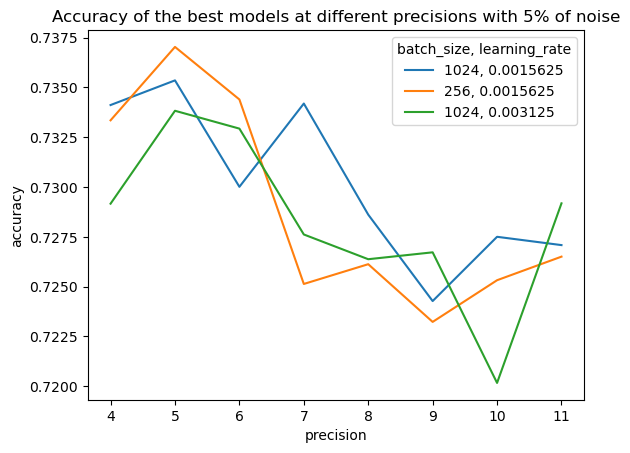

In [25]:
top_noise_df = top_noise_df.loc[
        (top_noise_df.batch_size == '1024') & (top_noise_df.learning_rate == '0.0015625') |
        (top_noise_df.batch_size == '256') & (top_noise_df.learning_rate == '0.0015625') |
        (top_noise_df.batch_size == '256') & (top_noise_df.learning_rate == '0.0015625') |
        (top_noise_df.batch_size == '1024') & (top_noise_df.learning_rate == '0.0015625') |
        (top_noise_df.batch_size == '1024') & (top_noise_df.learning_rate == '0.003125')
    ]
hue = top_noise_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_noise_df, x='precision', y='accuracy', hue=hue)
plt.title("Accuracy of the best models at different precisions with 5% of noise")
plt.show()

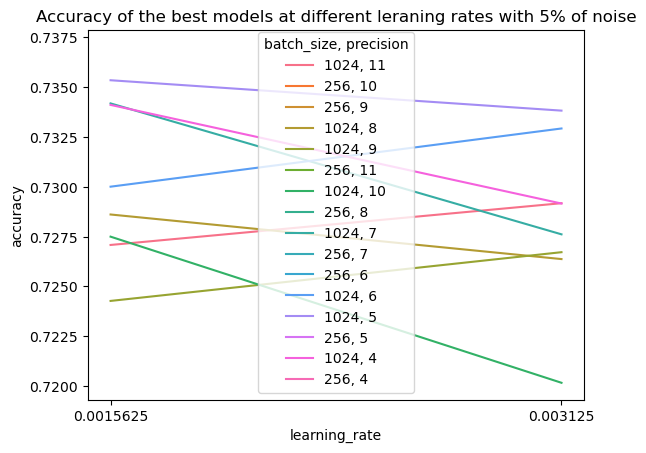

In [28]:
top_5_noise_df = top_noise_df.loc[
        (top_noise_df.batch_size == '1024') & (top_noise_df.precision == 11) |
        (top_noise_df.batch_size == '256') & (top_noise_df.precision == 10) |
        (top_noise_df.batch_size == '256') & (top_noise_df.precision == 9) |
        (top_noise_df.batch_size == '1024') & (top_noise_df.precision == 8) |
        (top_noise_df.batch_size == '1024') & (top_noise_df.precision == 9)
    ]
#top_5_noise_df = top_5_noise_df.sort_values(by='learning_rate', ascending=True)

hue = top_noise_df[['batch_size', 'precision']] \
        .apply(lambda row: f"{row.batch_size}, {row.precision}", axis=1)
hue.name = 'batch_size, precision'

sns.lineplot(top_noise_df, x='learning_rate', y='accuracy', hue=hue)
plt.title("Accuracy of the best models at different leraning rates with 5% of noise")
plt.show()

Let's look at the distribution of the accuracies per noise:

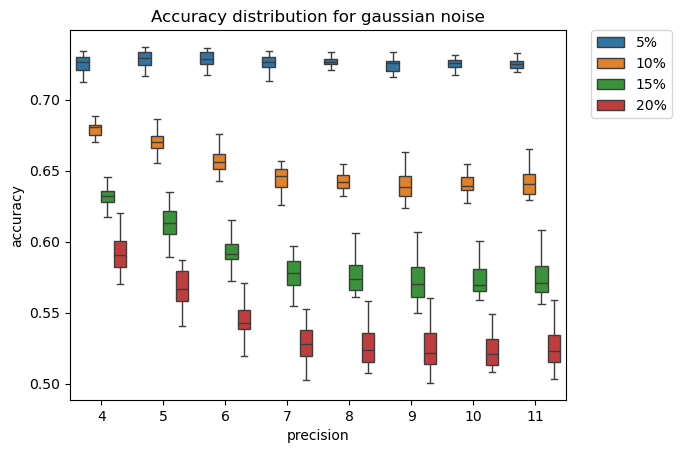

In [33]:
sns.boxplot(data=acc_distribution_df, 
            x='precision', 
            y='accuracy',
            hue='type',
            hue_order=['5%', '10%', '15%', '20%'],
            showfliers=False)

plt.title(f'Accuracy distribution for {noise_type} noise')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

Now we can focus only to those models that are more robust to noise.

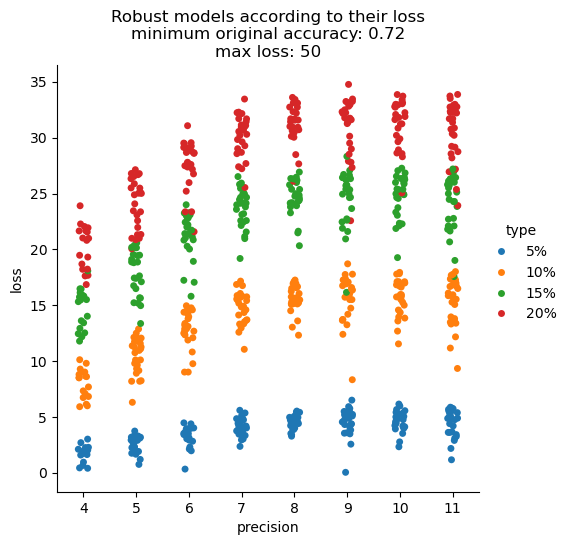

In [34]:
MAX_LOSS = 50
MIN_ACCURACY = 0.72
# filter the entries 
robust_df = acc_distribution_df.sort_values(by=['loss', 'original_acc'], ascending=[True, False])
robust_df = robust_df.drop(robust_df[robust_df.type == 'original'].index)
robust_df = robust_df.drop(robust_df[(robust_df.loss < 0) | (robust_df.loss > MAX_LOSS)].index)
robust_df = robust_df.drop(robust_df[robust_df.original_acc < MIN_ACCURACY].index)

sns.catplot(robust_df, y='loss', x='precision', hue='type', order=precisions)
plt.title(f'Robust models according to their loss\n' \
          f'minimum original accuracy: {MIN_ACCURACY}\n' \
          f'max loss: {MAX_LOSS}')
plt.show()

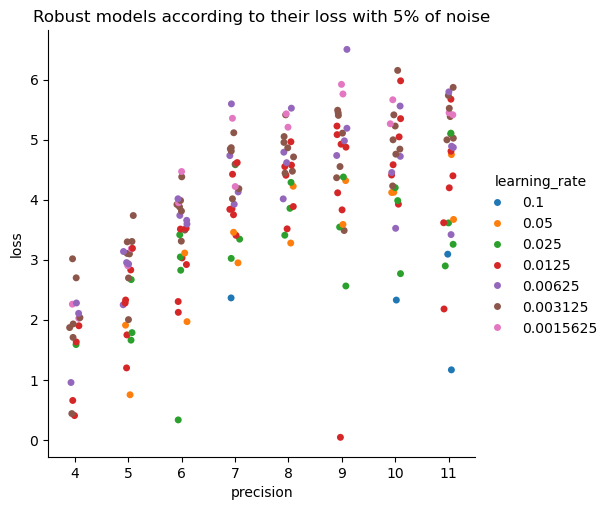

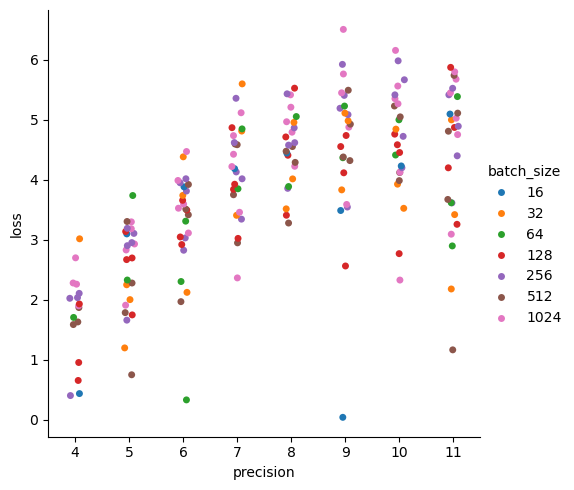

   original_acc      loss batch_size learning_rate  precision
0      0.723607  0.039499         16        0.0125          9
1      0.727575  0.329860         64         0.025          6
2      0.724667  0.402018        256        0.0125          4
3      0.730503  0.435083         16      0.003125          4
4      0.724456  0.653595        128        0.0125          4
     original_acc      loss batch_size learning_rate  precision
187      0.766607  5.869263        128      0.003125         11
188      0.768732  5.919164        256     0.0015625          9
189      0.763453  5.978211        256        0.0125         10
190      0.767376  6.152024       1024      0.003125         10
191      0.767274  6.501803       1024       0.00625          9


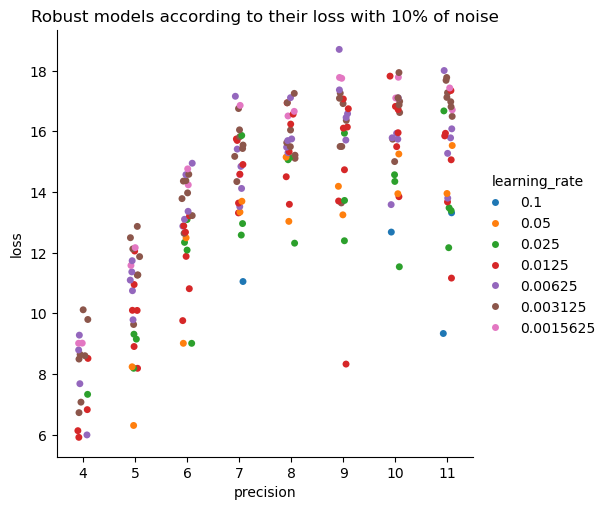

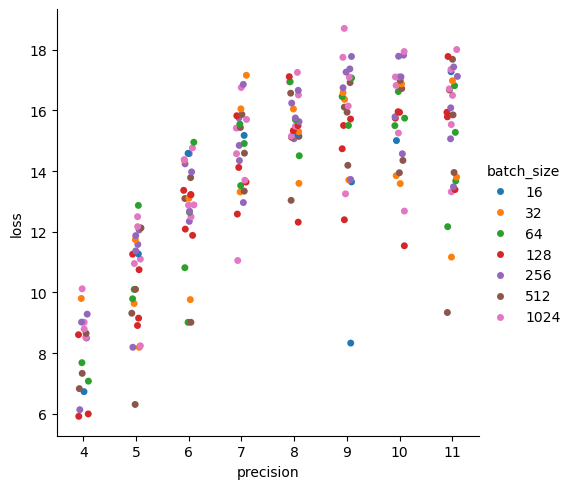

   original_acc      loss batch_size learning_rate  precision
0      0.724456  5.915595        128        0.0125          4
1      0.731738  5.994967        128       0.00625          4
2      0.724667  6.134537        256        0.0125          4
3      0.732465  6.306673        512          0.05          5
4      0.730503  6.729264         16      0.003125          4
     original_acc       loss batch_size learning_rate  precision
195      0.768859  17.785658        256     0.0015625         10
196      0.763453  17.821866        256        0.0125         10
197      0.767376  17.940033       1024      0.003125         10
198      0.767520  18.007020       1024       0.00625         11
199      0.767274  18.703548       1024       0.00625          9


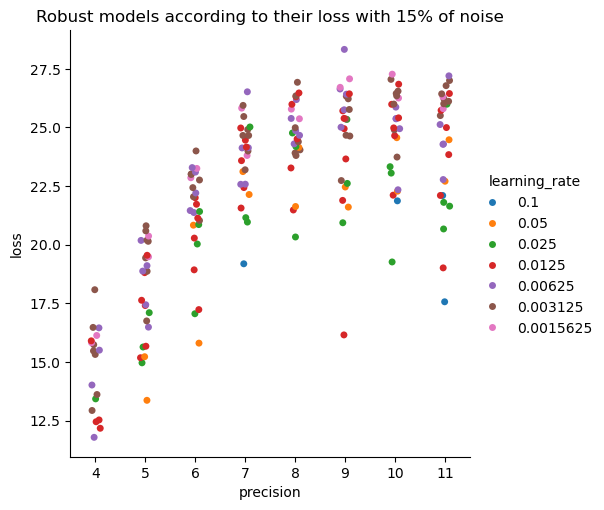

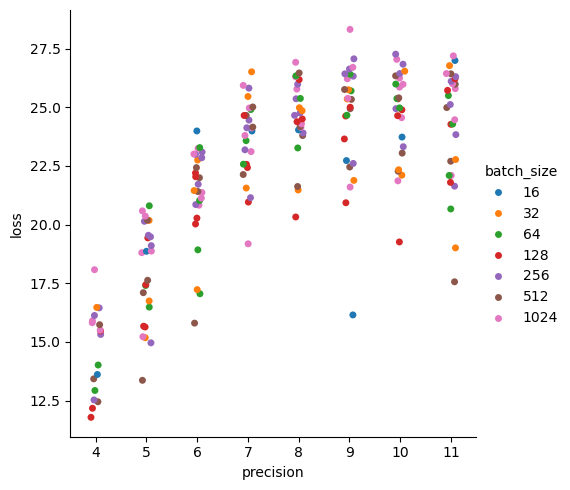

   original_acc       loss batch_size learning_rate  precision
0      0.731738  11.784264        128       0.00625          4
1      0.724456  12.170860        128        0.0125          4
2      0.735757  12.448411        512        0.0125          4
3      0.724667  12.525976        256        0.0125          4
4      0.740774  12.928930         64      0.003125          4
     original_acc       loss batch_size learning_rate  precision
195      0.767376  27.045741       1024      0.003125         10
196      0.768732  27.068722        256     0.0015625          9
197      0.767520  27.196249       1024       0.00625         11
198      0.768859  27.267238        256     0.0015625         10
199      0.767274  28.323641       1024       0.00625          9


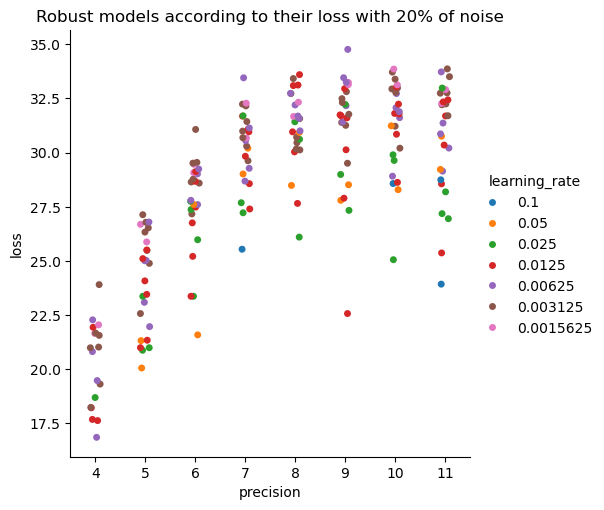

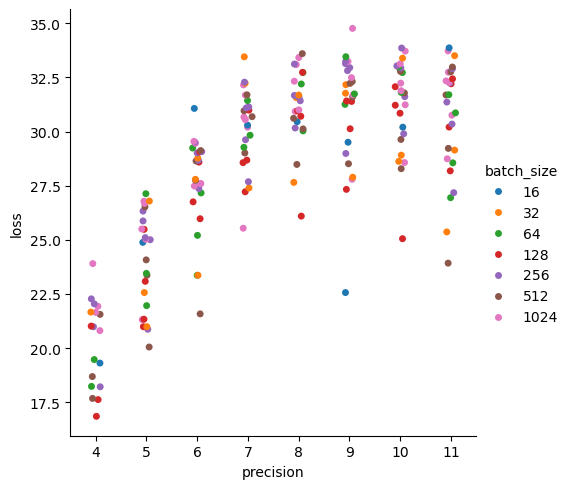

   original_acc       loss batch_size learning_rate  precision
0      0.731738  16.848691        128       0.00625          4
1      0.724456  17.621500        128        0.0125          4
2      0.735757  17.676017        512        0.0125          4
3      0.724667  18.213067        256        0.0125          4
4      0.740774  18.231378         64      0.003125          4
     original_acc       loss batch_size learning_rate  precision
195      0.767376  33.718922       1024      0.003125         10
196      0.767520  33.727567       1024       0.00625         11
197      0.768859  33.860339        256     0.0015625         10
198      0.761423  33.868371         16      0.003125         11
199      0.767274  34.767452       1024       0.00625          9


In [35]:
noise_levels = [5, 10, 15, 20]
for noise in noise_levels:
    # Check the most robust models per noise
    df = robust_df.drop(robust_df[robust_df.type != f'{noise}%'].index)
    df = df.reset_index()
    
    sns.catplot(df, 
                x='precision', 
                y='loss', 
                hue='learning_rate', 
                order=precisions, 
                hue_order=[str(x) for x in learning_rates])
    plt.title(f'Robust models according to their loss with {noise}% of noise')
    sns.catplot(df, 
                x='precision', 
                y='loss', 
                hue='batch_size', 
                order=precisions, 
                hue_order=[str(x) for x in batch_sizes])
    plt.show()
    print(df[['original_acc', 'loss', 'batch_size', 'learning_rate', 'precision']].head(5))
    print(df[['original_acc', 'loss', 'batch_size', 'learning_rate', 'precision']].tail(5))
    df.to_csv(f"./out{noise}_{noise_type}.csv")

plots of the best models in terms of loss.

In [52]:
noise = 5 # 5 10 15 20
top_noise_df = robust_df.loc[robust_df.type == f'{noise}%']
top_noise_df = top_noise_df.sort_values(by='loss', ascending=True)
top_noise_df = top_noise_df.reset_index()
top_noise_df.head(5)

index  precision  accuracy type batch_size learning_rate      loss  \
0   1241          9  0.723321   5%         16        0.0125  0.039499   
1    571          6  0.725175   5%         64         0.025  0.329860   
2    156          4  0.721754   5%        256        0.0125  0.402018   
3     26          4  0.727325   5%         16      0.003125  0.435083   
4    121          4  0.719721   5%        128        0.0125  0.653595   

   original_acc  
0      0.723607  
1      0.727575  
2      0.724667  
3      0.730503  
4      0.724456

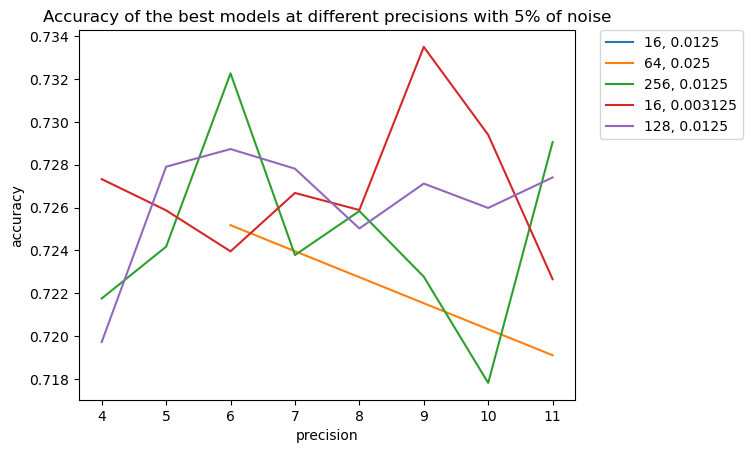

In [53]:
top_noise_df = top_noise_df.loc[
        (top_noise_df.batch_size == '16') & (top_noise_df.learning_rate == '0.0125') |
        (top_noise_df.batch_size == '64') & (top_noise_df.learning_rate == '0.025') |
        (top_noise_df.batch_size == '256') & (top_noise_df.learning_rate == '0.0125') |
        (top_noise_df.batch_size == '16') & (top_noise_df.learning_rate == '0.003125') |
        (top_noise_df.batch_size == '128') & (top_noise_df.learning_rate == '0.0125')
    ]
hue = top_noise_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_noise_df, x='precision', y='accuracy', hue=hue)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title(f"Accuracy of the best models at different precisions with {noise}% of noise")
plt.show()